# <span style='font-family:"Times New Roman"'> <span styel=''> **COHORT SUBGROUPS CREATION**

## <span style='font-family:"Times New Roman"'> <span styel=''> *Emile Cohen* 
*March 2020*

**Goal:** In this notebook, we create subgroups of the cohort, based on their Copy Number State and their mutational profile. For that we create functions to visualize vaf distributions, ccf distributions and vaf1 vs vaf2 for defined groups.
    
The Notebook is divided in 2 parts:
   
* **1. Function Definition**
* **2. Loading Master**
* **3. Group Creation**
* **4. Group Analysis**

**NB1:** In each part, you must run the cells from the begining in order to initialize the variables

**NB2:** All functions used for the plots are located in utils/custom_tools.py

---

In [84]:
%run -i '../../utils/setup_environment.ipy'
from utils.analysis_tools import *

import warnings, math
warnings.filterwarnings('ignore')
import ptitprince as pt

data_path = '../../data/'

Setup environment... done!


<span style="color:green">✅ Working on **mskimpact_env** conda environment.</span>

---
## Function Definition

In this part we define the needed functions to plot summaries of each subgroup.

---

The following *f1, f2* and *f3* allow to recompute the ccf (cancer cell fraction), based on Teng repository Github (https://github.com/papaemmelab/driverclone/blob/master/utils.r#L124-L175)

In [2]:
def f1(x):
    if math.isnan(x.exp_nb_1):
        return float('NaN')
    else: 
        if x.exp_nb_1 >= 1 :
            m_star = round(x.exp_nb_1)
        else : m_star = 1
        return (x.exp_nb_1/m_star)
    
def f2(x):
    if math.isnan(x.exp_nb_2):
        return float('NaN')
    else: 
        if x.exp_nb_2 >= 1 :
            m_star = round(x.exp_nb_2)
        else : m_star = 1
        return (x.exp_nb_2/m_star)
    
def f3(x):
    if math.isnan(x.exp_nb_3):
        return float('NaN')
    else: 
        if x.exp_nb_3 >= 1 :
            m_star = round(x.exp_nb_3)
        else : m_star = 1
        return (x.exp_nb_3/m_star)

We define 4 functions that will allow us to print easily the summary report of our subgroups.

1. plot_ccf_vaf
2. plot_scatters
3. plot_purity_numbers
4. plot_copies_tcn
5. plot_summary

In [3]:
def plot_ccf_vaf(data, group_name):
    
    data_vaf = list(data['vaf_1']) + list(data['vaf_2']) + list(data['vaf_3'])
    data_ccf = list(data['ccf_1']) + list(data['ccf_2']) + list(data['ccf_3'])
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3), sharex=True)
    f.suptitle(group_name+' SUMMARY', fontsize=16)
    
    sns.distplot(data_vaf, kde_kws={'clip': (0.0, 1.0)}, hist=False, ax=ax1)
    ax1.set_ylabel('Density Estimation')
    ax1.set_xlabel('VAF of TP53 mutations')

    sns.distplot(data_ccf, hist=False, ax=ax2)
    ax2.set_xlabel('CCF of TP53 mutations')
    
    plt.show()

    
    
def plot_scatters(data, group_name):
    
    data_vaf = data[['vaf_1', 'vaf_2', 'vaf_3']]
    max_table_vaf = pd.DataFrame(np.sort(data_vaf.fillna(0).values)[:,-2:], columns=['2nd-largest','largest'])
    max_table_vaf = pd.concat([max_table_vaf, data.reset_index().cn_state], axis=1)
    
    data_ccf = data[['ccf_1', 'ccf_2', 'ccf_3']]
    max_table_ccf = pd.DataFrame(np.sort(data_ccf.fillna(0).values)[:,-2:], columns=['2nd-largest','largest'])
    max_table_ccf = pd.concat([max_table_ccf, data.reset_index().cn_state], axis=1)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharex=True)
    
    sns.scatterplot(x='largest', y='2nd-largest', data=max_table_vaf, hue='cn_state', ax=ax1)
    ax1.plot([0,1], [0,1], linewidth=0.5, color='grey')
    ax1.set_ylabel('VAF_2')
    ax1.set_xlabel('VAF_1')
    ax1.set_title('VAF', weight = 'bold')
    
    sns.scatterplot(x='largest', y='2nd-largest', data=max_table_ccf, hue='cn_state', ax=ax2)
    ax2.plot([0,1], [0,1], linewidth=0.5, color='grey')
    ax2.set_ylabel('CCF_2')
    ax2.set_xlabel('CCF_1')
    ax2.set_title('CCF', weight = 'bold')
    
    plt.show()
    
def plot_purity_numbers(data, group, group_name): 
    f, axs = plt.subplots(1, 2, figsize=(14, 4))
    ax1 = axs[0]
    sns.distplot(data['purity'], hist=False,kde_kws={'clip': (0.0, 1.0)}, ax=ax1)
    ax1.set_xlim([0,1])
    ax1.set_xlabel('Purity')
    ax1.set_ylabel('Density Estimation')
    ax1.set_title('Purity', weight = 'bold')
    
    ax2 = axs[1]
    #sns.distplot(data['exp_nb_1'], hist=False, label=group_name, ax=ax2, color='black')
    for cn_state in group:
        sns.distplot(data[data['cn_state'] == cn_state]['exp_nb_1'], hist=False, label = cn_state, ax=ax2)
    ax2.set_xlim([-1,6])
    ax2.set_xlabel('Expected copies of tp53 mutations')
    ax2.set_ylabel('Density Estimation')
    ax2.set_title('Expected number of mutants copies per cell', weight = 'bold')

def plot_copies_tcn(data, group, group_name, nb_muts):
    data = filter_muts(data, nb_muts)
    data_1 =  pd.DataFrame(data[['Tumor_Id','exp_nb_1']])
    data_1.columns = ['Tumor_Id', 'exp_nb']
    data_2 = pd.DataFrame(data[['Tumor_Id','exp_nb_2']])
    data_2.columns = ['Tumor_Id', 'exp_nb']
    data_3 = pd.DataFrame(data[['Tumor_Id','exp_nb_3']])
    data_3.columns = ['Tumor_Id', 'exp_nb']
    data_tot = data_1.append(data_2)
    data_tot = data_tot.append(data_3)
    
    data_tot = pd.merge(left=data_tot, right=data[['Tumor_Id','cn_state', 'tcn']],how='left', left_on='Tumor_Id',right_on='Tumor_Id')

    data_multi = filter_muts(data, [2,3])
    dx="tcn"; dy="exp_nb"; ort="h"; pal = "muted"; sigma = .2; dhue = "cn_state"
    f, ax = plt.subplots(figsize=(15, 10))

    ax=pt.RainCloud(x = dx, y = dy, data = data_tot, palette = pal, bw = sigma, hue=dhue,
                 width_viol = .6, ax = ax, orient = ort, alpha=.6, mv=.2)
    ax.set_ylabel('Total Copy Number')
    ax.set_xlabel('Expected number of copies of Tp53 mutations')
    ax.set_title('Determining subgroups with WT alleles for 1mut', weight = 'bold')

In [4]:
def plot_summary( group: list, group_name: str, nb_muts_density=[1,2,3], nb_muts_scatter=[2,3]):
    sns.set_style("whitegrid", {'grid.color': '.95'})
    sns.set_palette("muted", len(group),1)
    # DENSITY PLOTS
    master_density = filter_muts(master, nb_muts_density)
    master_density = filter_cn_state(master_density, group)
    display(get_groupby(master_density, 'cn_state', 'count'))
    #master_density = master_density[master_density['wgd'] == 1]
    plot_ccf_vaf(master_density, group_name)
    
    # SCATTER PLOTS
    master_scatter = filter_muts(master, nb_muts_scatter)
    master_scatter = filter_cn_state(master_scatter, group)
    plot_scatters(master_scatter, group_name)
    
    # Plot Purity distribution and expected number of mutants copy distribution
    plot_purity_numbers(master_density, group, group_name)
    
    # Plot number of mut copies VS tcn 
    plot_copies_tcn(master_density, group, group_name, [1])

---
## Loading Master

We load the master file and create 3 new columns: for each mutation we compute a Cancer Cell Fraction (CCF), from the Lab Github. This CCF is uncapped and go above 1, contrary to the one given in the Facets output.

In [5]:
# LOADING THE MASTER FILE
master = pd.read_pickle(data_path + 'merged_data/master_file.pkl')

master['ccf_comp_1'] = master.apply(f1, axis = 1)
master['ccf_comp_2'] = master.apply(f2, axis = 1)
master['ccf_comp_3'] = master.apply(f3, axis = 1)
#filter_muts(master, [1,2,3])

---
## Group Creation

In [6]:
# Groups definition
WT_present = ['DIPLOID', 'TETRAPLOID', 'LOSS AFTER', 'DOUBLE LOSS AFTER']
loh = ['CNLOH', 'CNLOH BEFORE & LOSS', 'CNLOH AFTER', 'CNLOH BEFORE', 'CNLOH & GAIN', 'CNLOH BEFORE & GAIN', 'AMP (LOH)']
loss_withorwithout_WT = ['HETLOSS', 'LOSS BEFORE', 'HOMDEL', 'LOSS BEFORE & AFTER']
gain = ['GAIN', 'AMP', 'AMP (BALANCED)', 'LOSS & GAIN']

In [7]:
# Groups definition
LOH = ['CNLOH', 'CNLOH BEFORE & LOSS', 'CNLOH AFTER', 'CNLOH BEFORE', 'CNLOH & GAIN', 'CNLOH BEFORE & GAIN', 'AMP (LOH)']
LOSS = ['HETLOSS', 'LOSS BEFORE', 'LOSS AFTER', 'HOMDEL', 'LOSS BEFORE & AFTER', 'DOUBLE LOSS AFTER']
GAIN = ['GAIN', 'AMP', 'AMP (BALANCED)', 'LOSS & GAIN', 'TETRAPLOID']
DIPLOID = ['DIPLOID']
indeterminate = ['INDETERMINATE']
total = LOH + LOSS + GAIN + DIPLOID

In [8]:
# Group Definition
WT_allele = ['LOSS AFTER', 'DIPLOID', 'TETRAPLOID']
LOSS_noWT = ['LOSS BEFORE', 'HETLOSS', 'LOSS BEFORE & AFTER']
LOH_noWT = ['CNLOH', 'CNLOH BEFORE & LOSS', 'CNLOH BEFORE', 'CNLOH BEFORE & GAIN']
GAIN_WT = ['AMP', 'GAIN','LOSS & GAIN']
AMBIGUOUS = ['CNLOH AFTER', 'DOUBLE LOSS AFTER']
MISSING = ['HOMDEL', 'AMP (BALANCED)', 'AMP (LOH)']

---
## Data Exploration

count
cn_state         
DIPLOID      1711
LOSS AFTER    271
TETRAPLOID     82

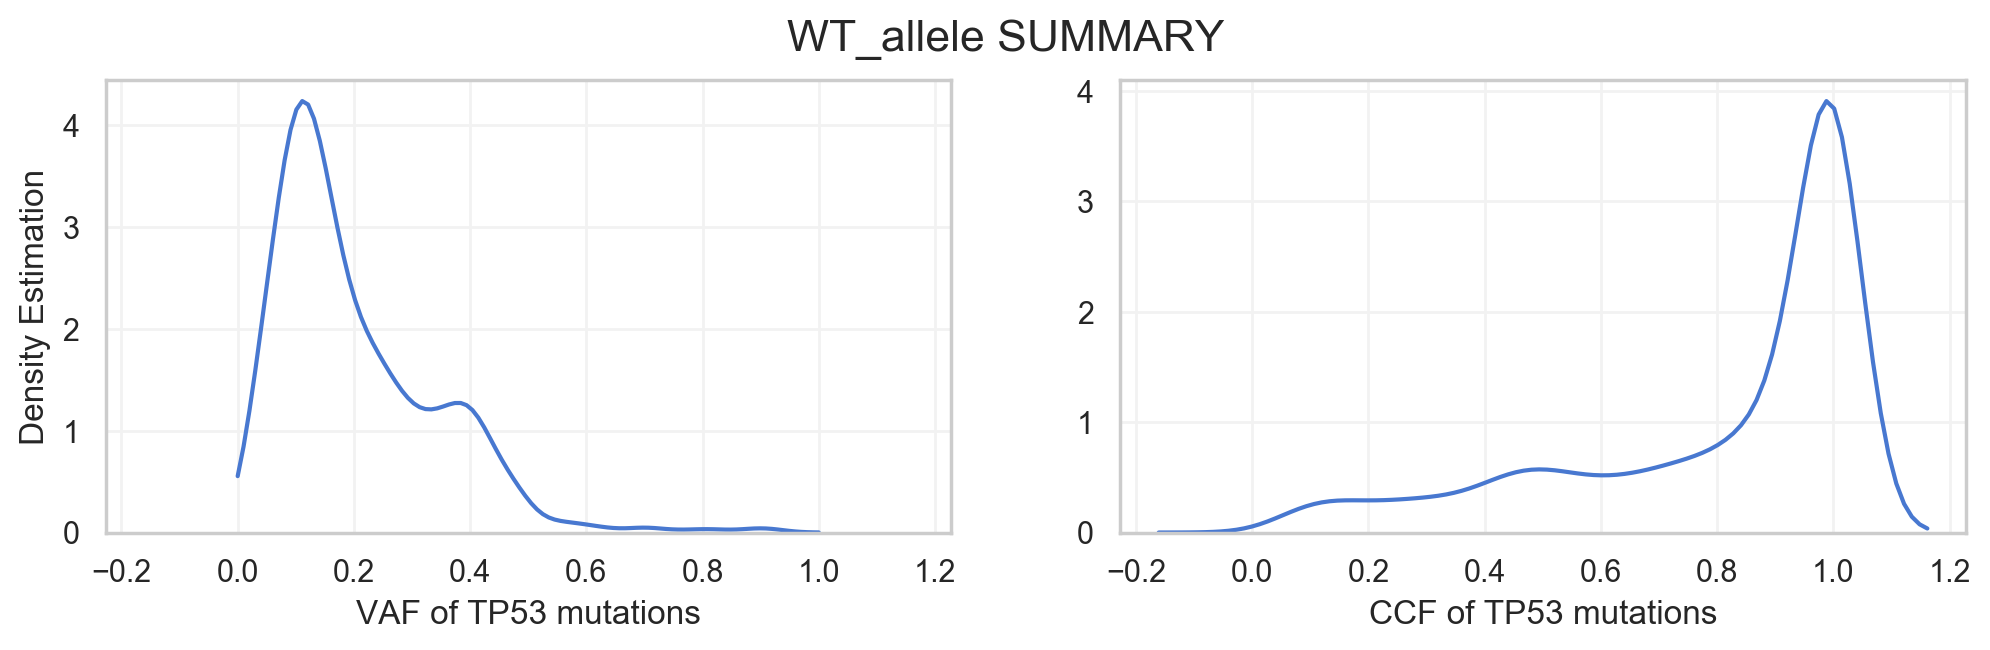

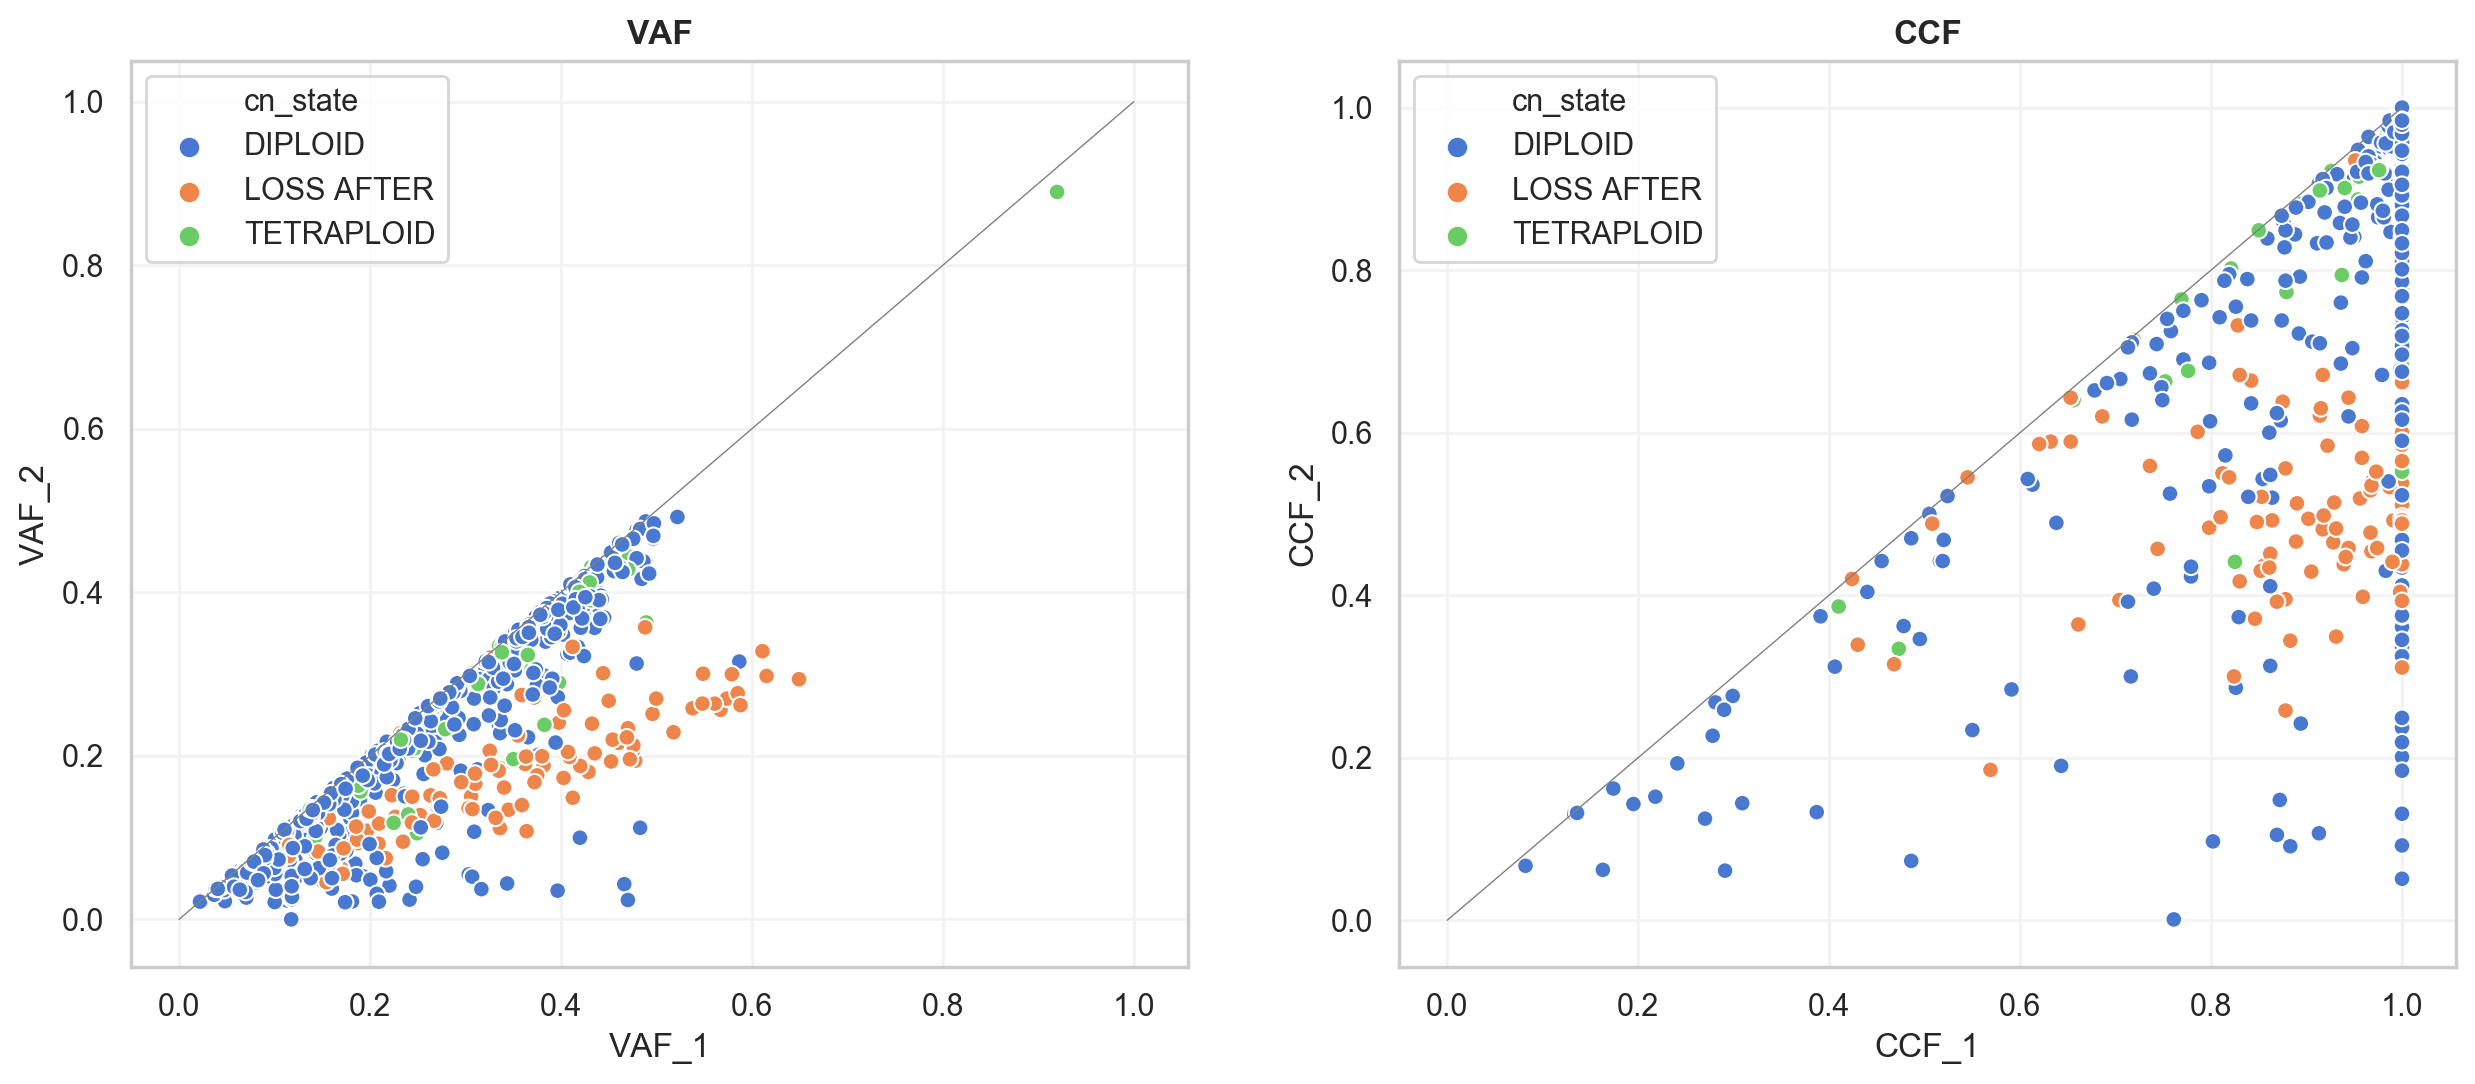

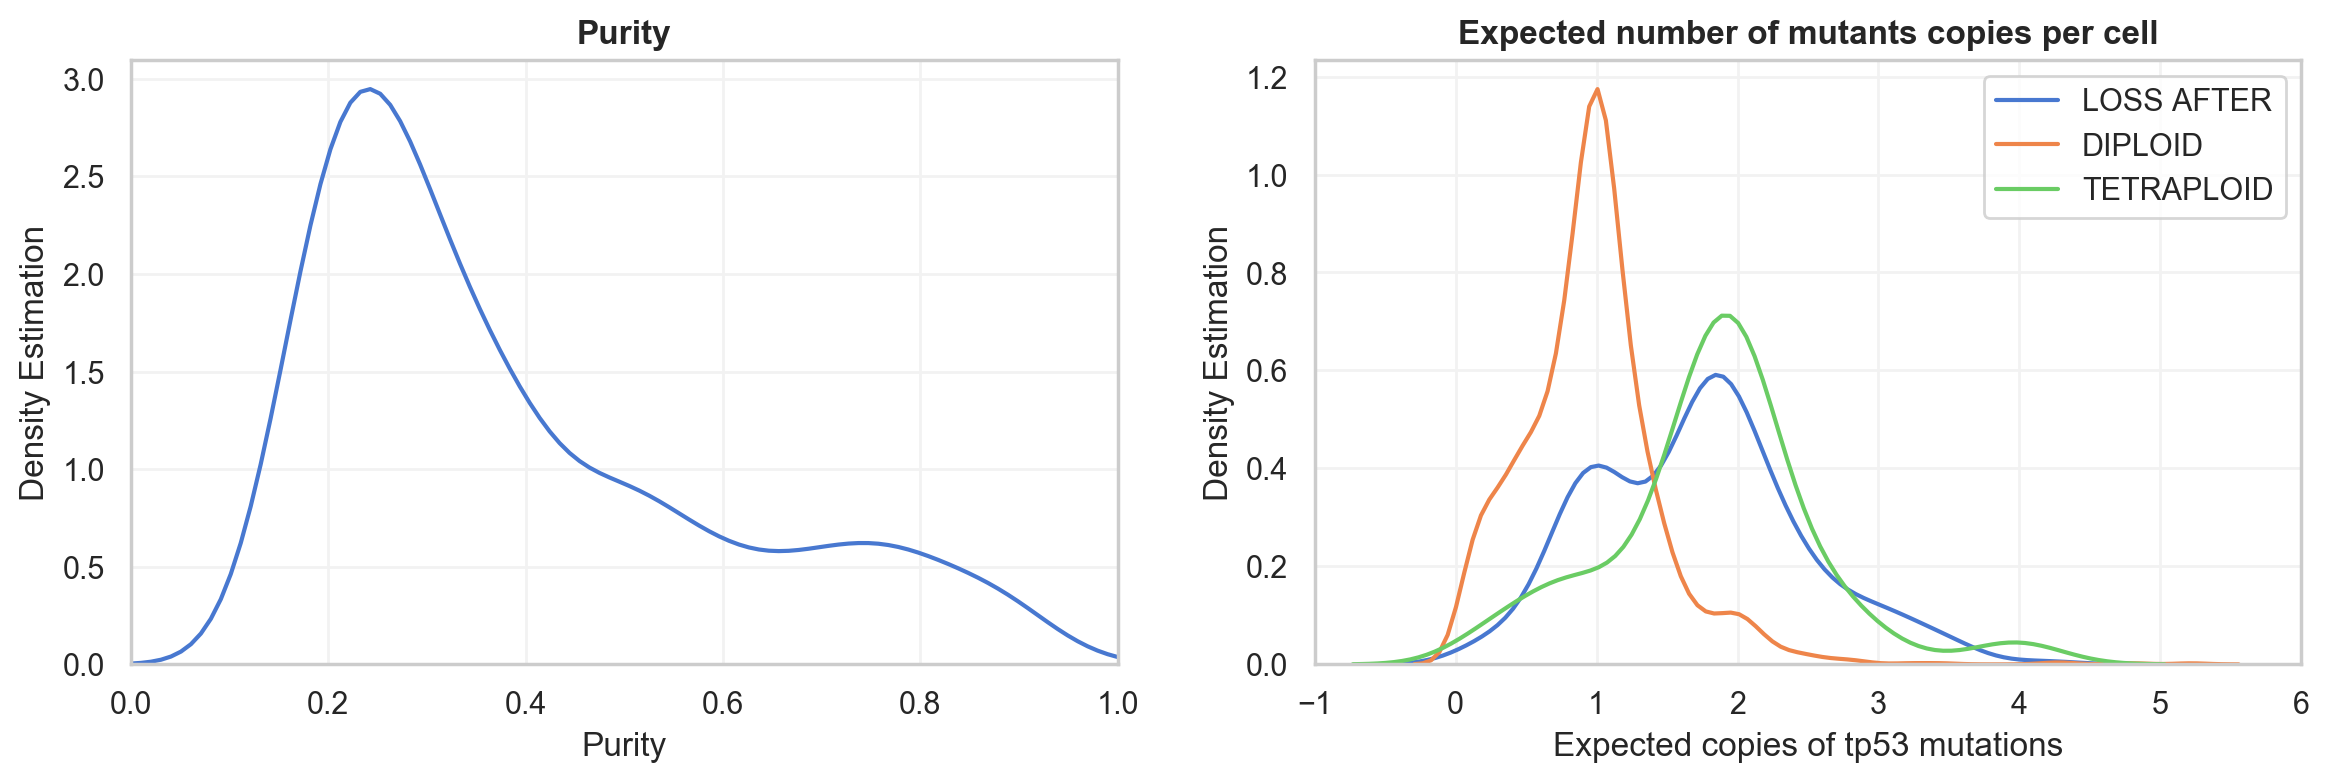

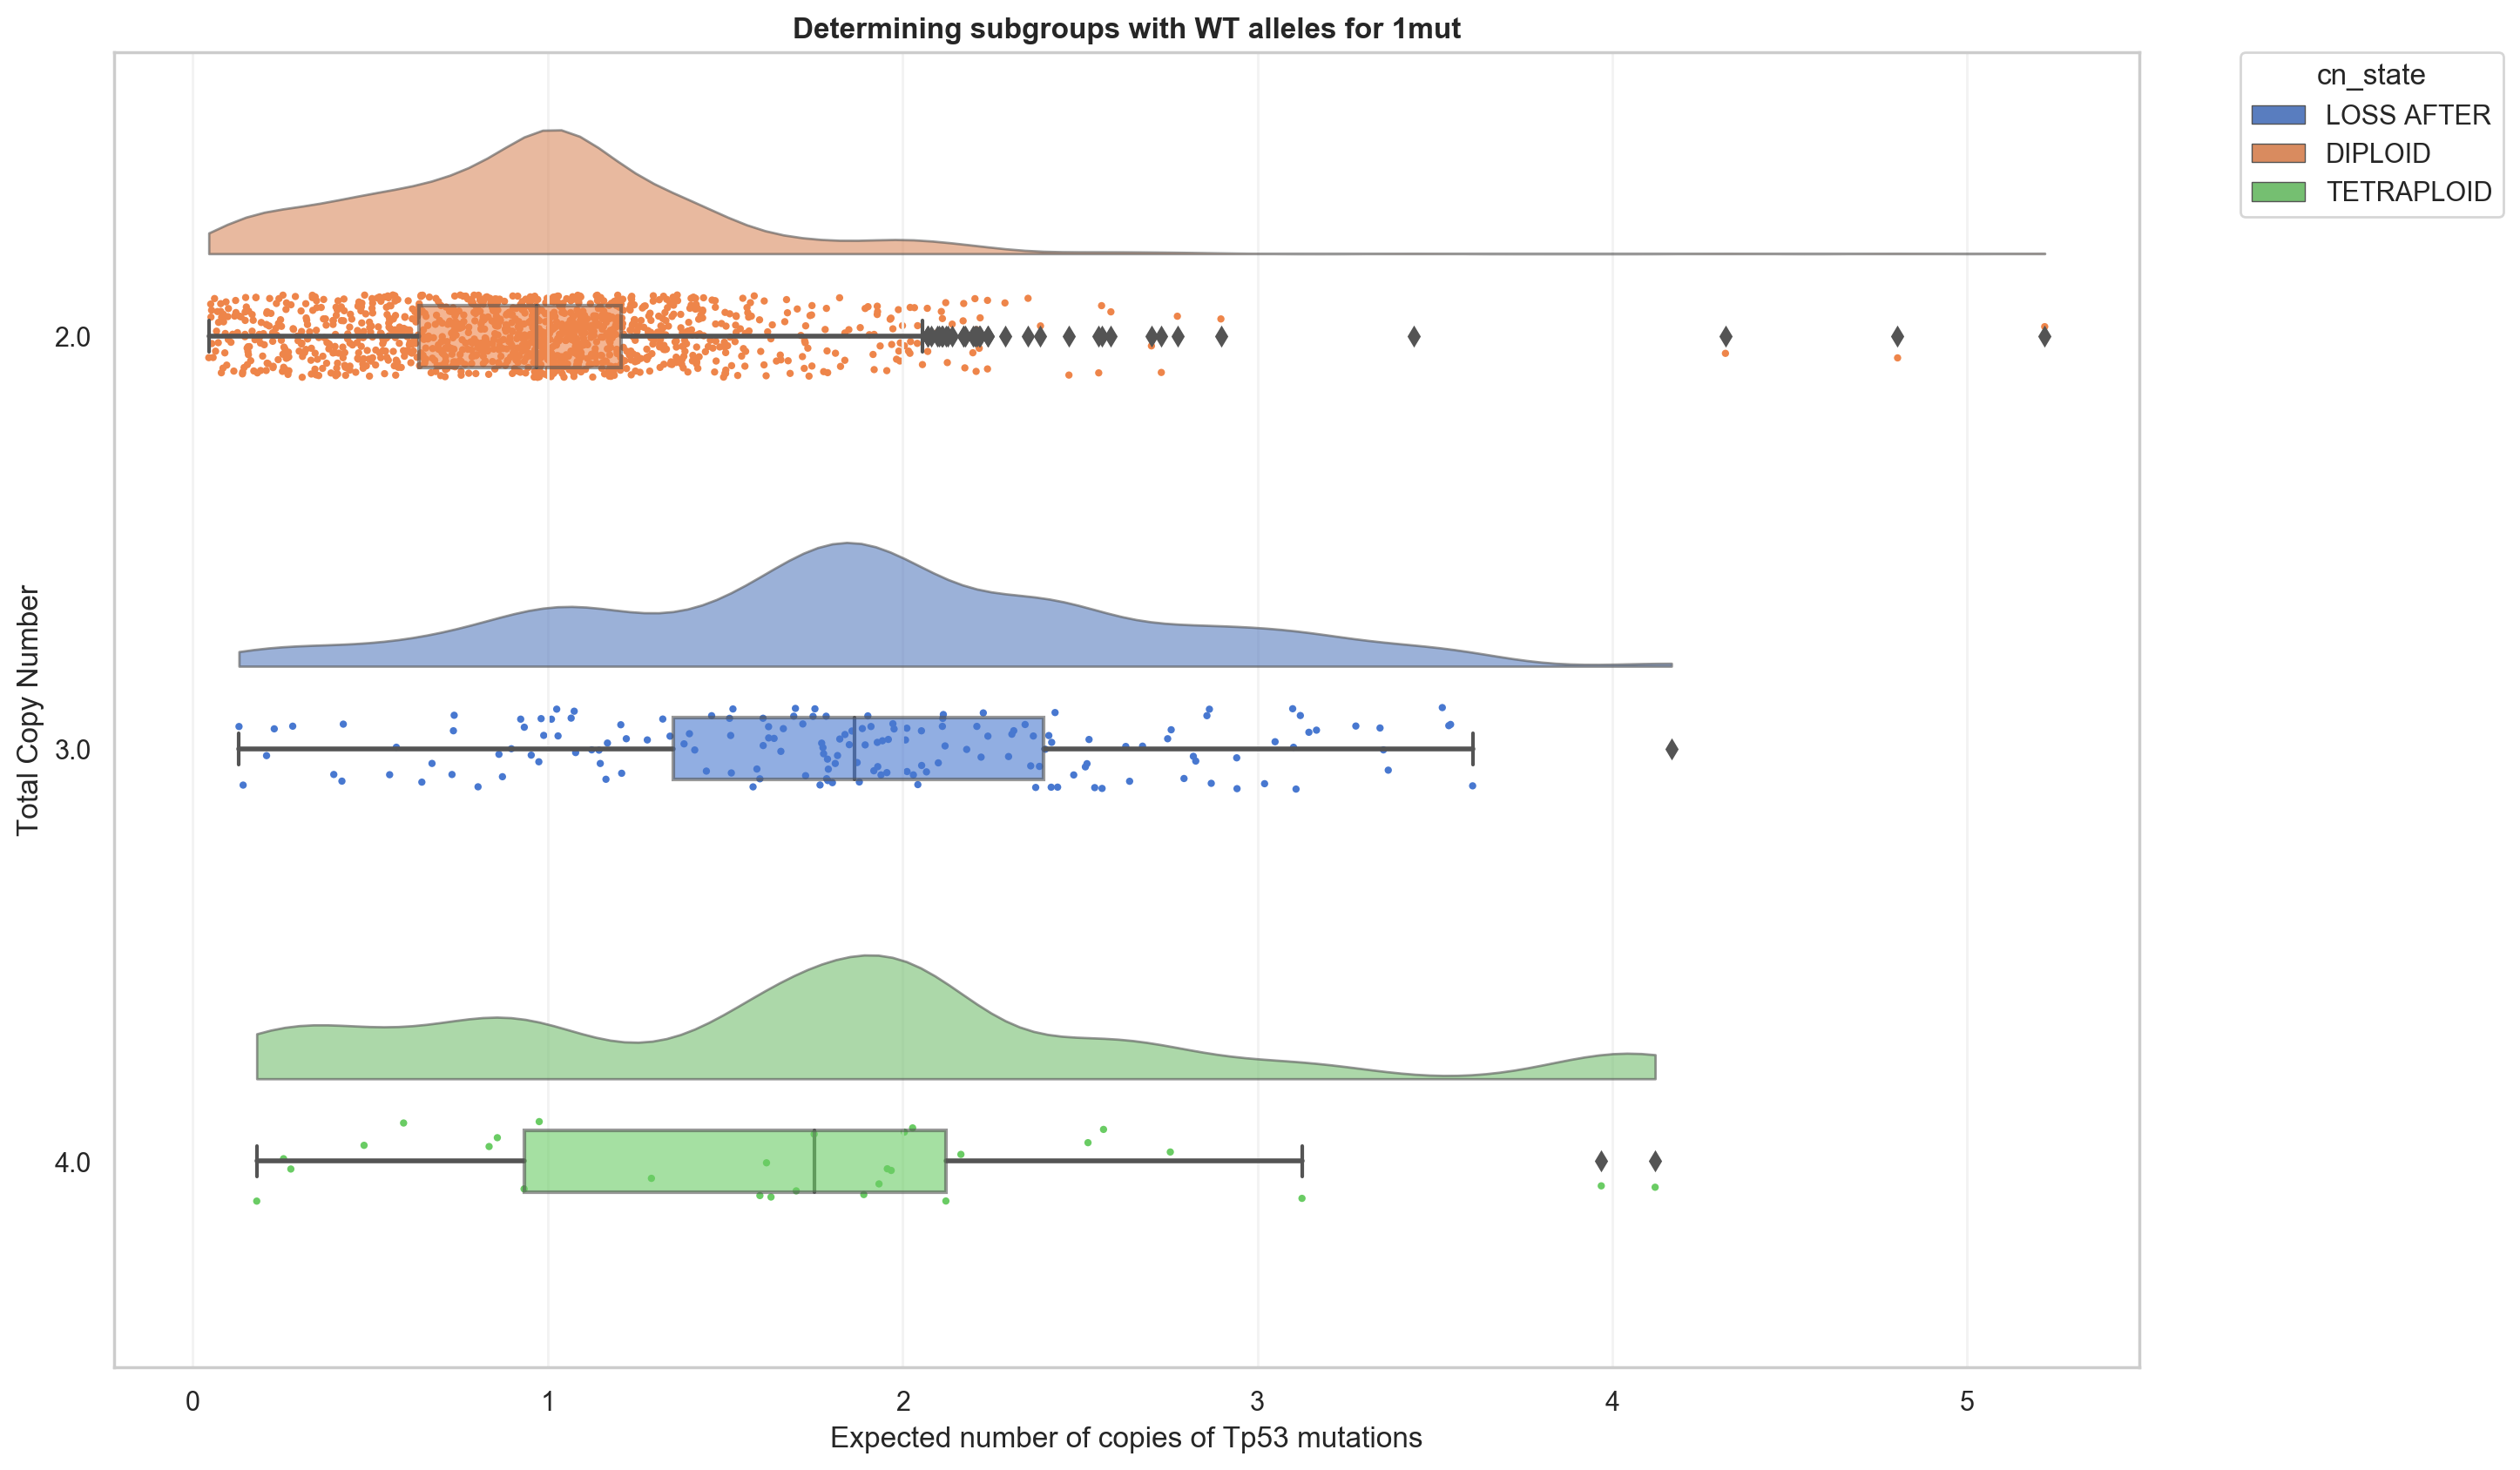

In [17]:
plot_summary(WT_allele,'WT_allele')

count
cn_state                  
HETLOSS               3727
LOSS BEFORE           3131
LOSS BEFORE & AFTER    226

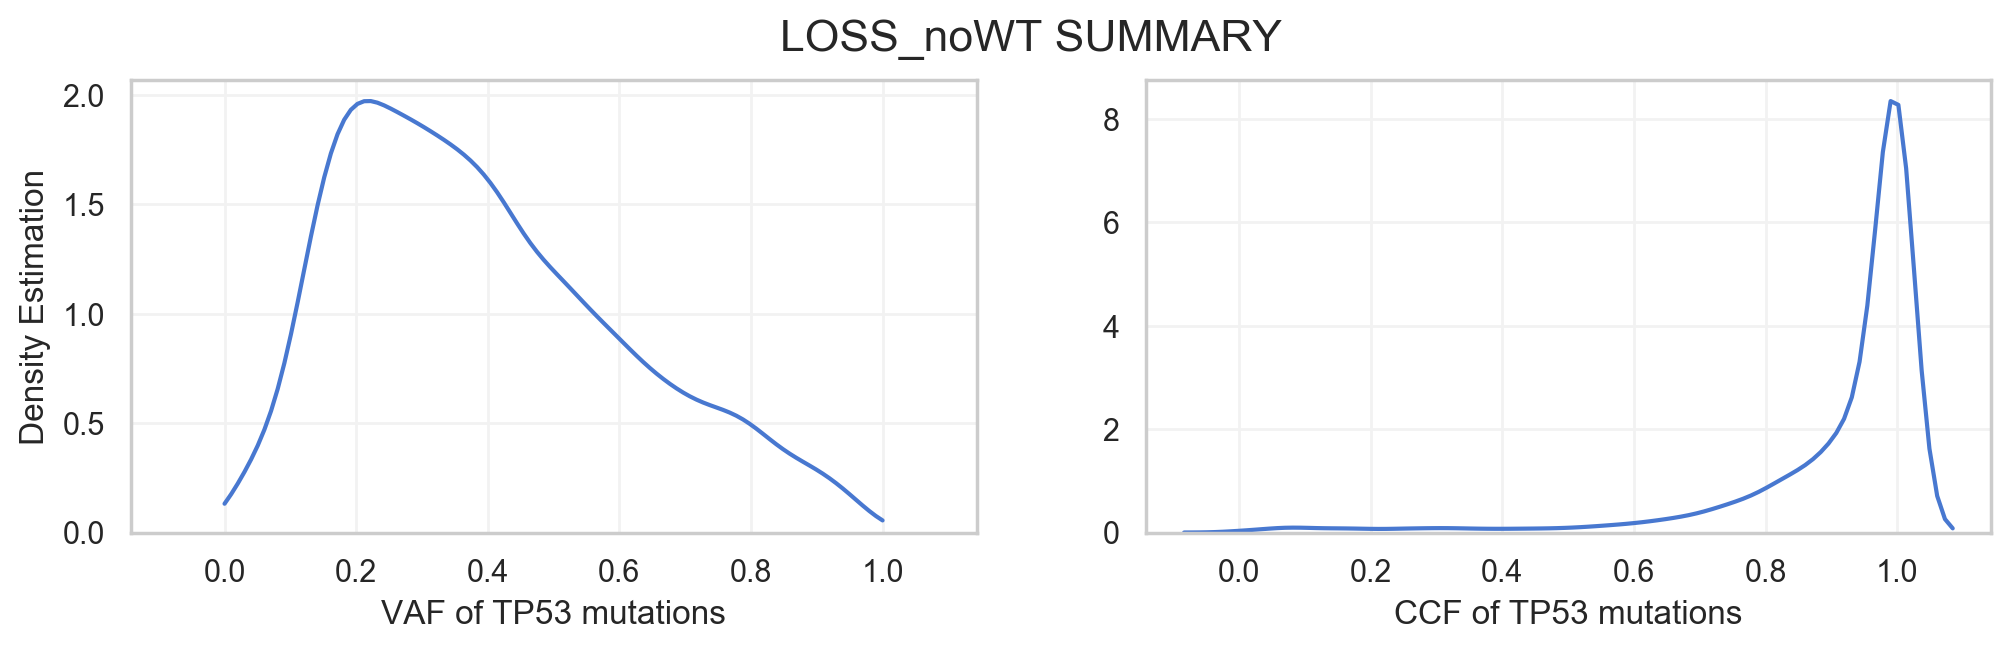

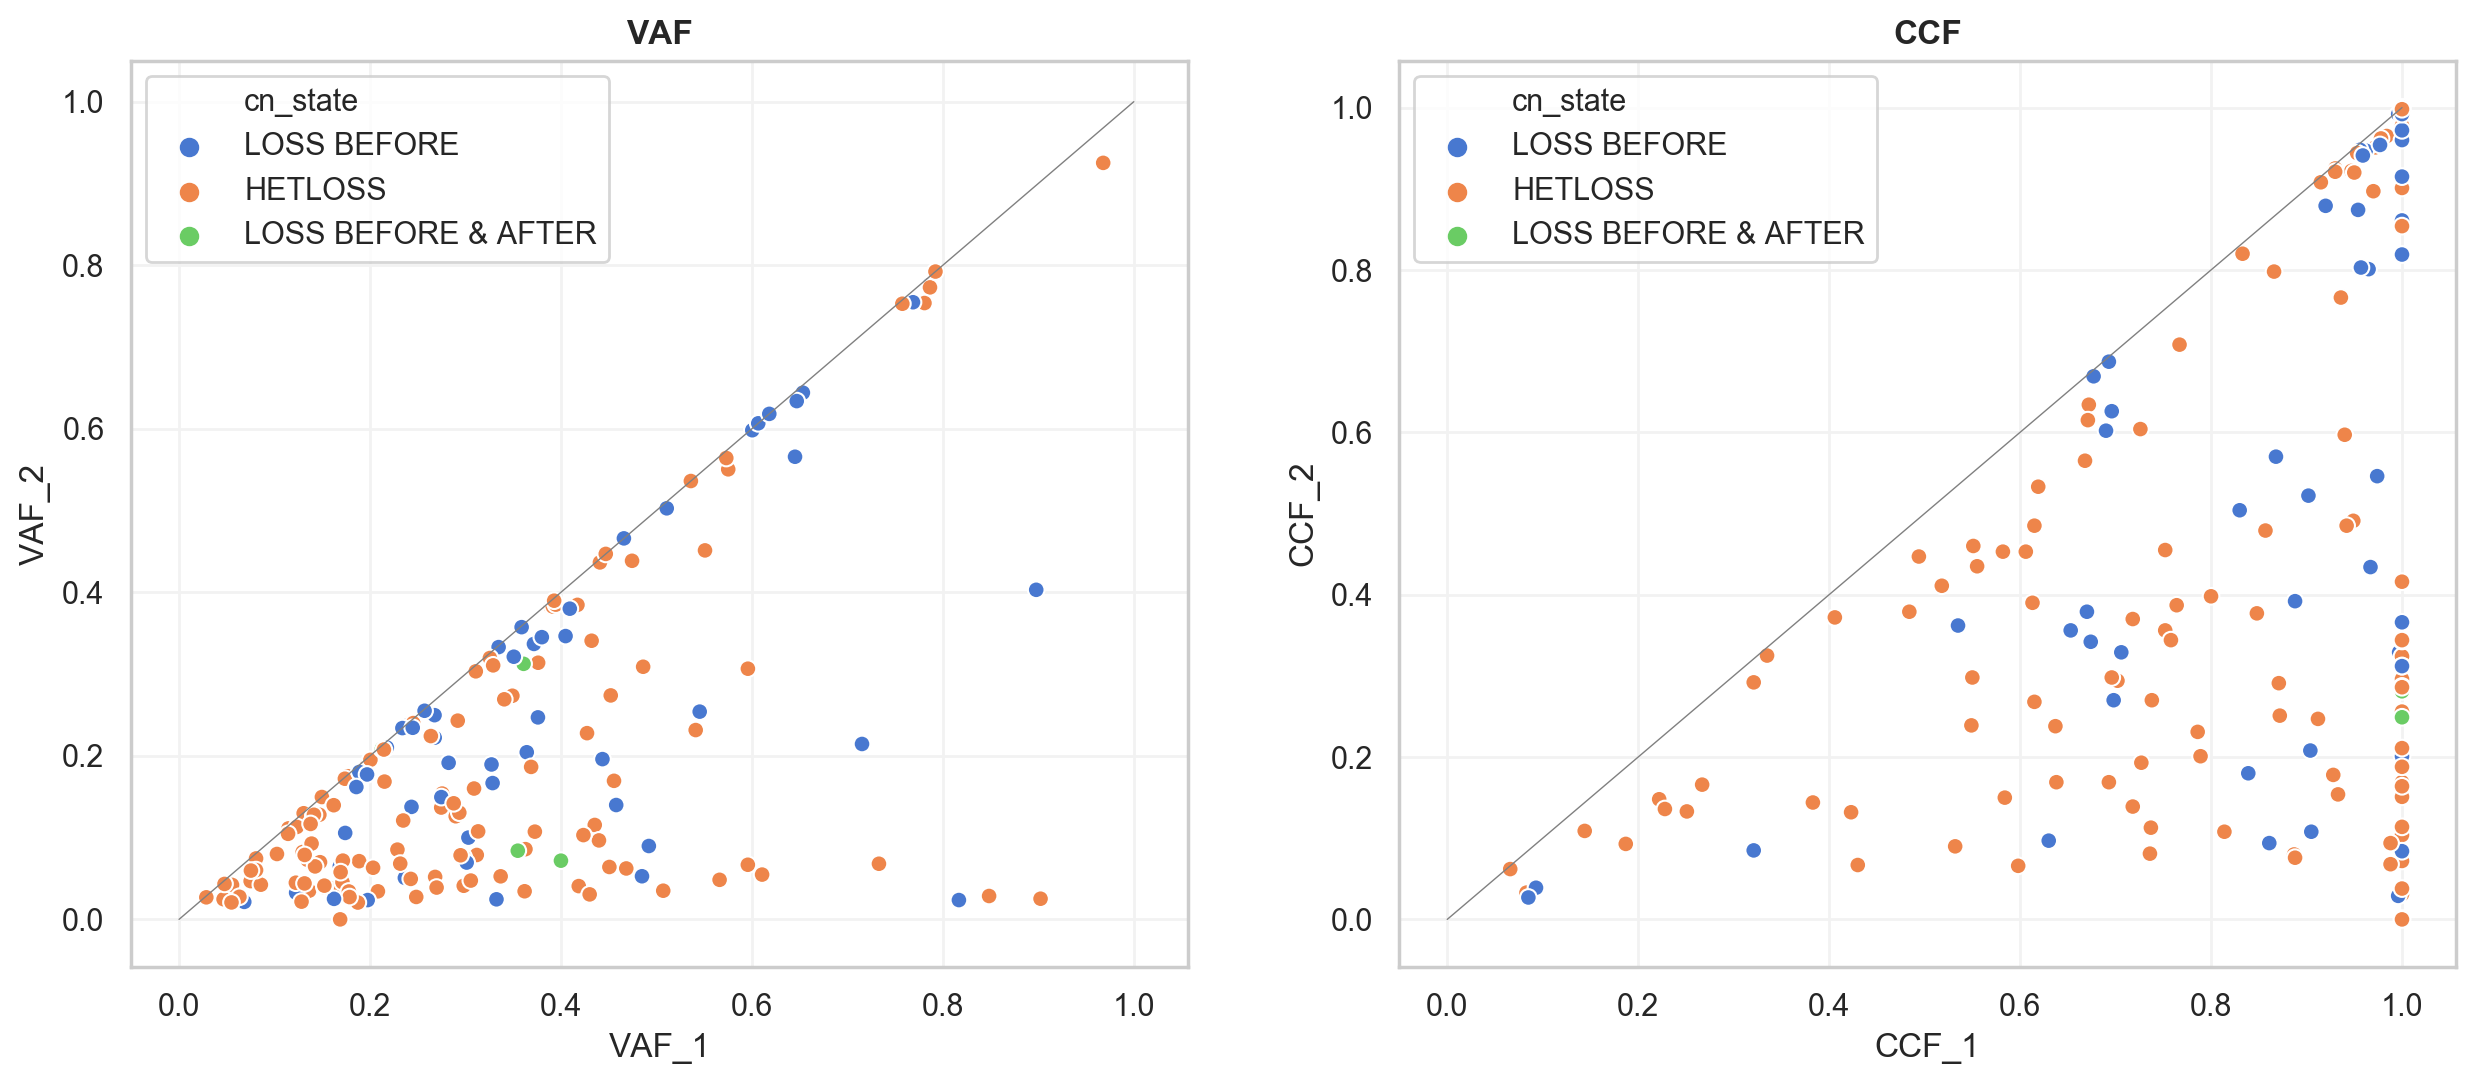

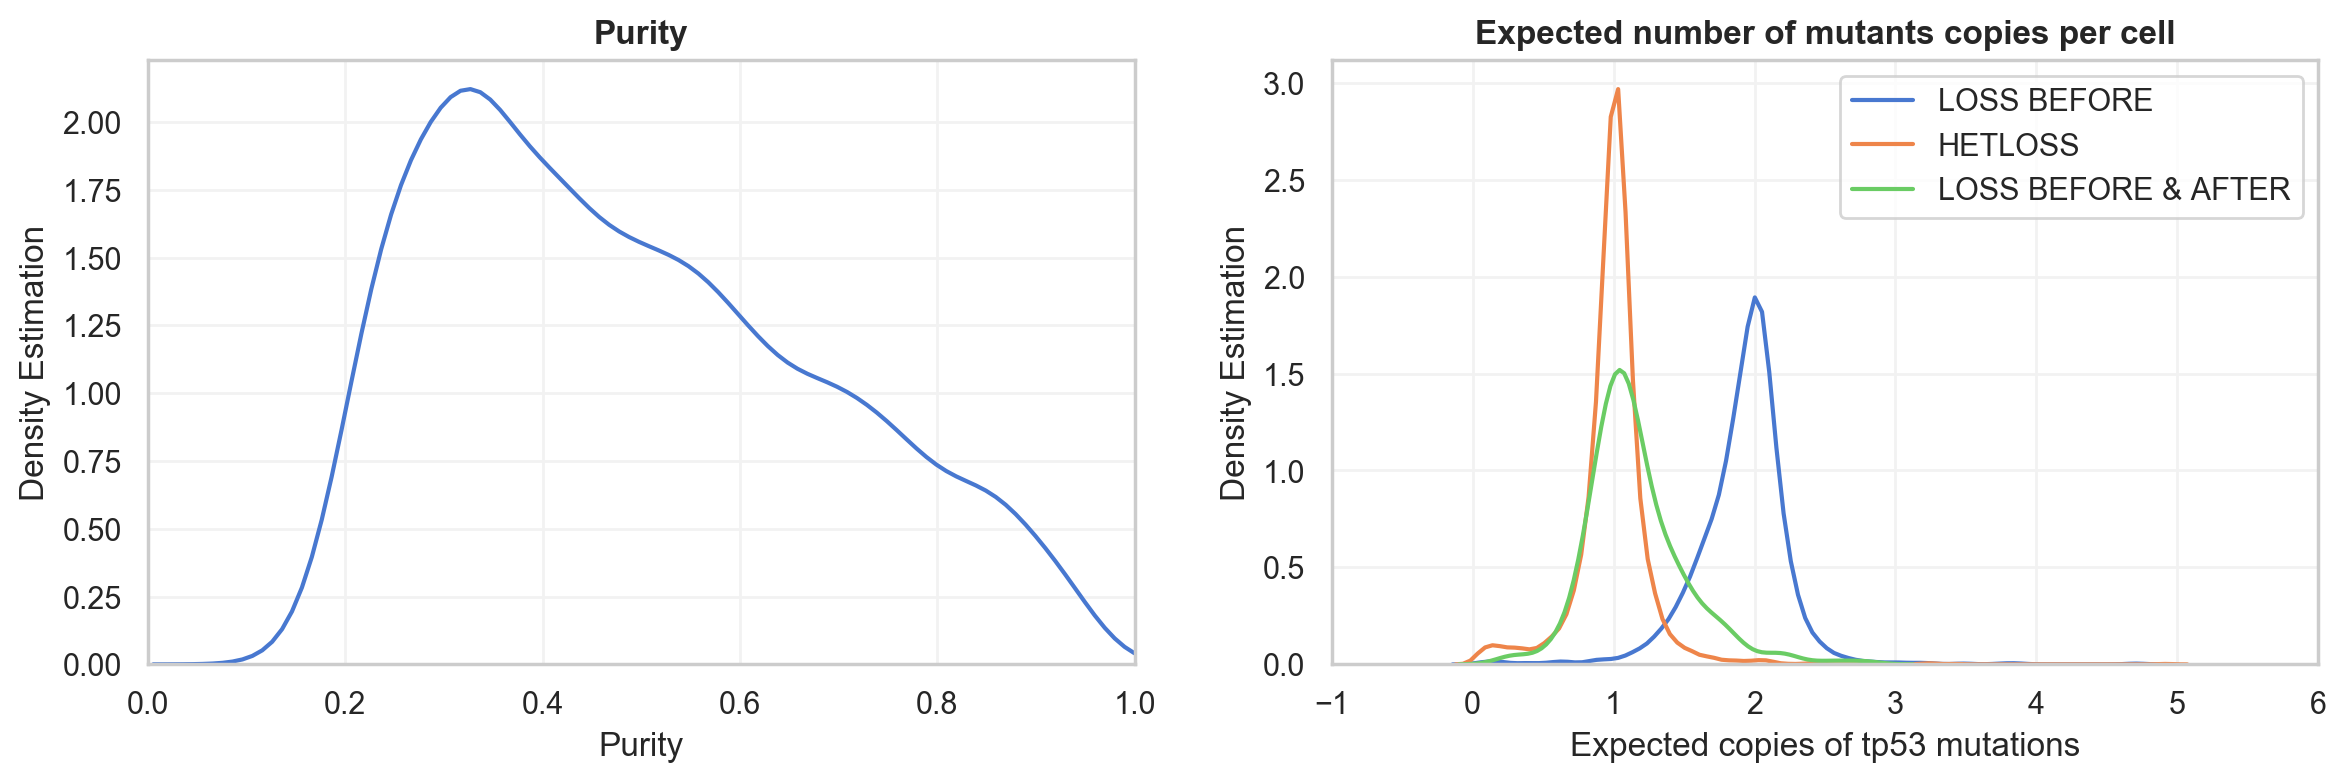

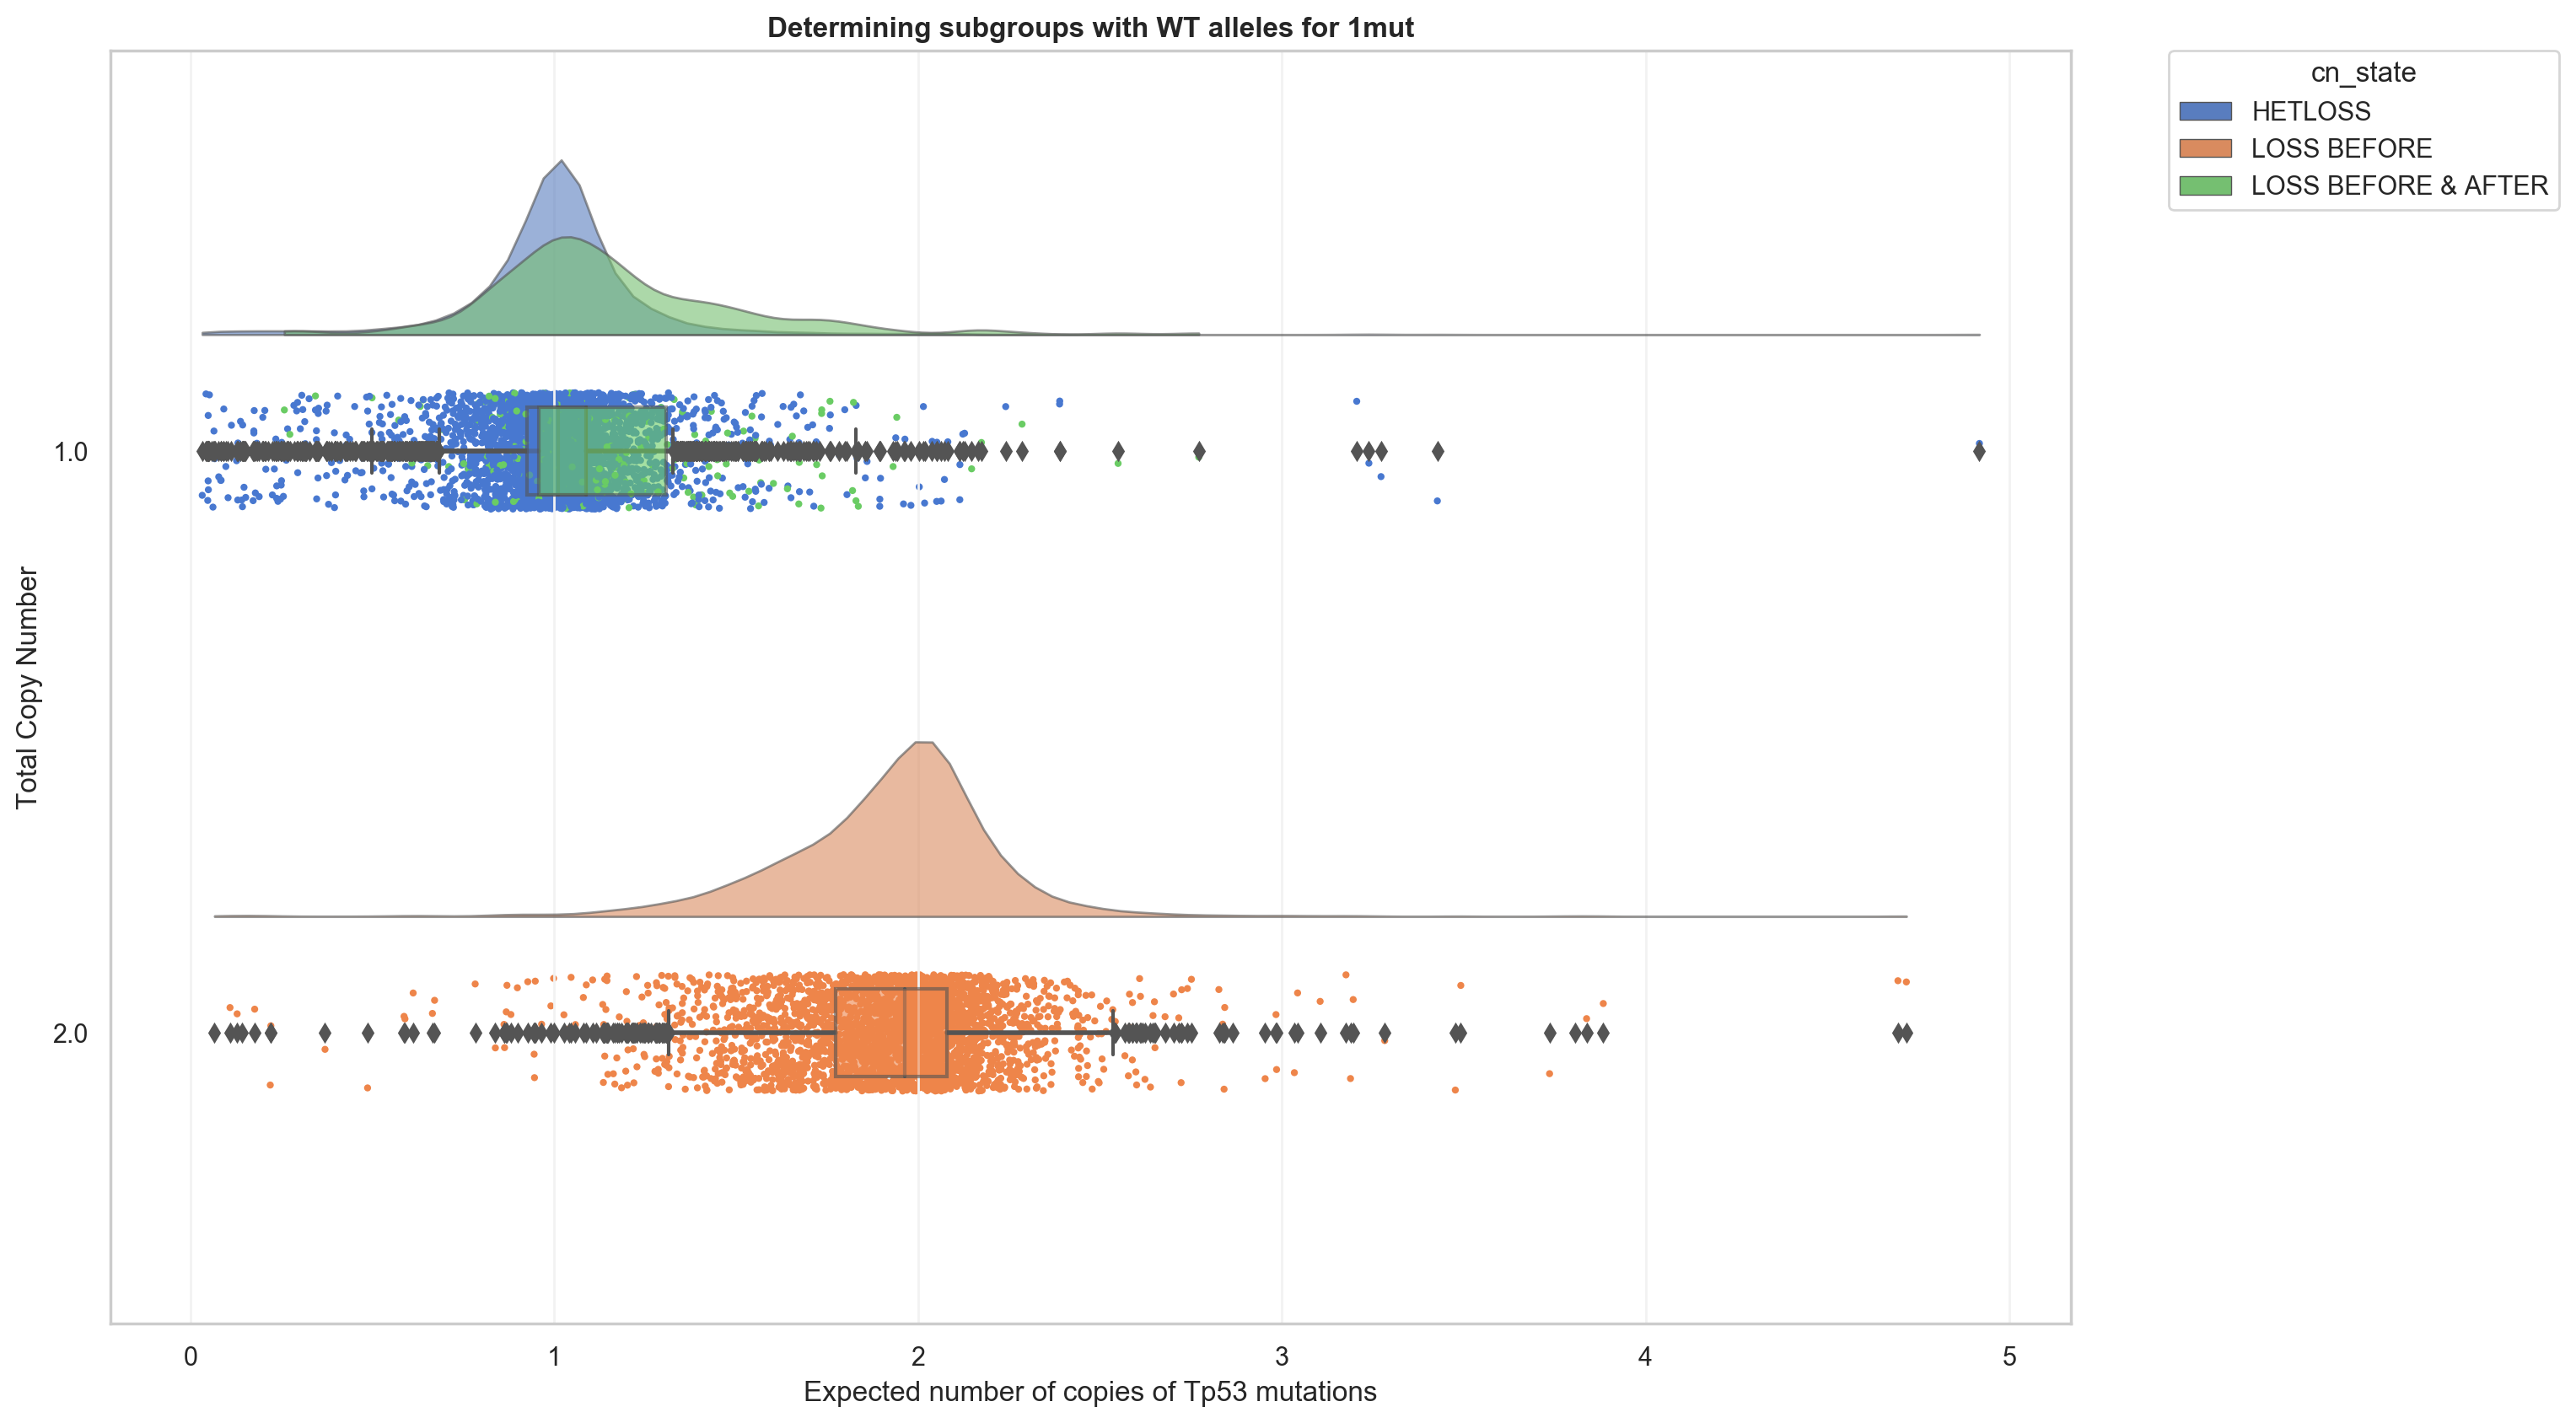

In [138]:
plot_summary(LOSS_noWT,'LOSS_noWT')

count
cn_state                  
AMP (LOH)               12
CNLOH                  802
CNLOH & GAIN            61
CNLOH AFTER             43
CNLOH BEFORE           174
CNLOH BEFORE & GAIN     26
CNLOH BEFORE & LOSS    893

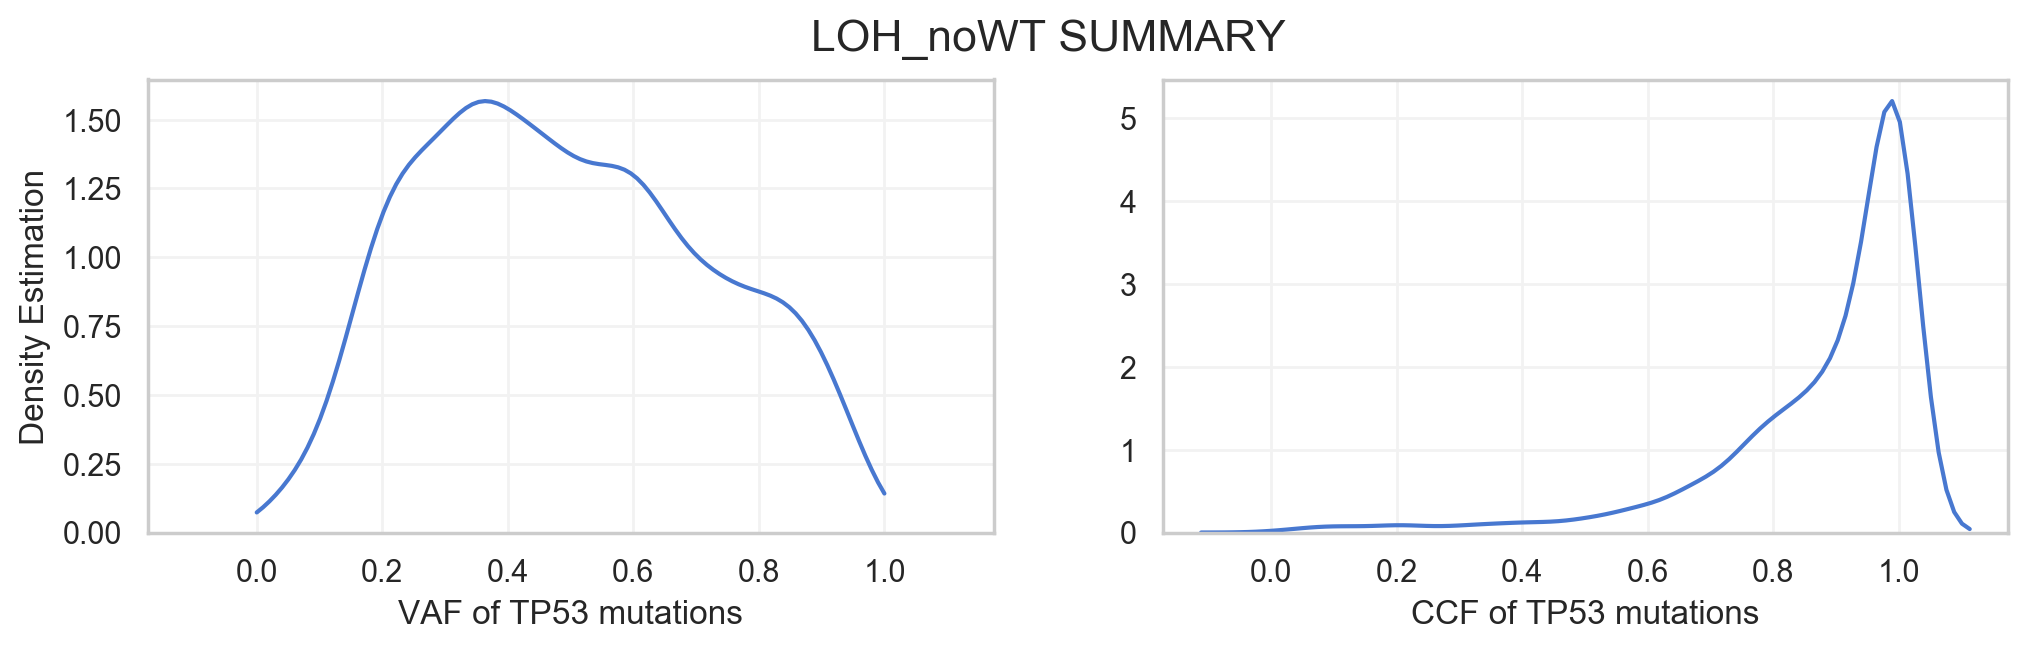

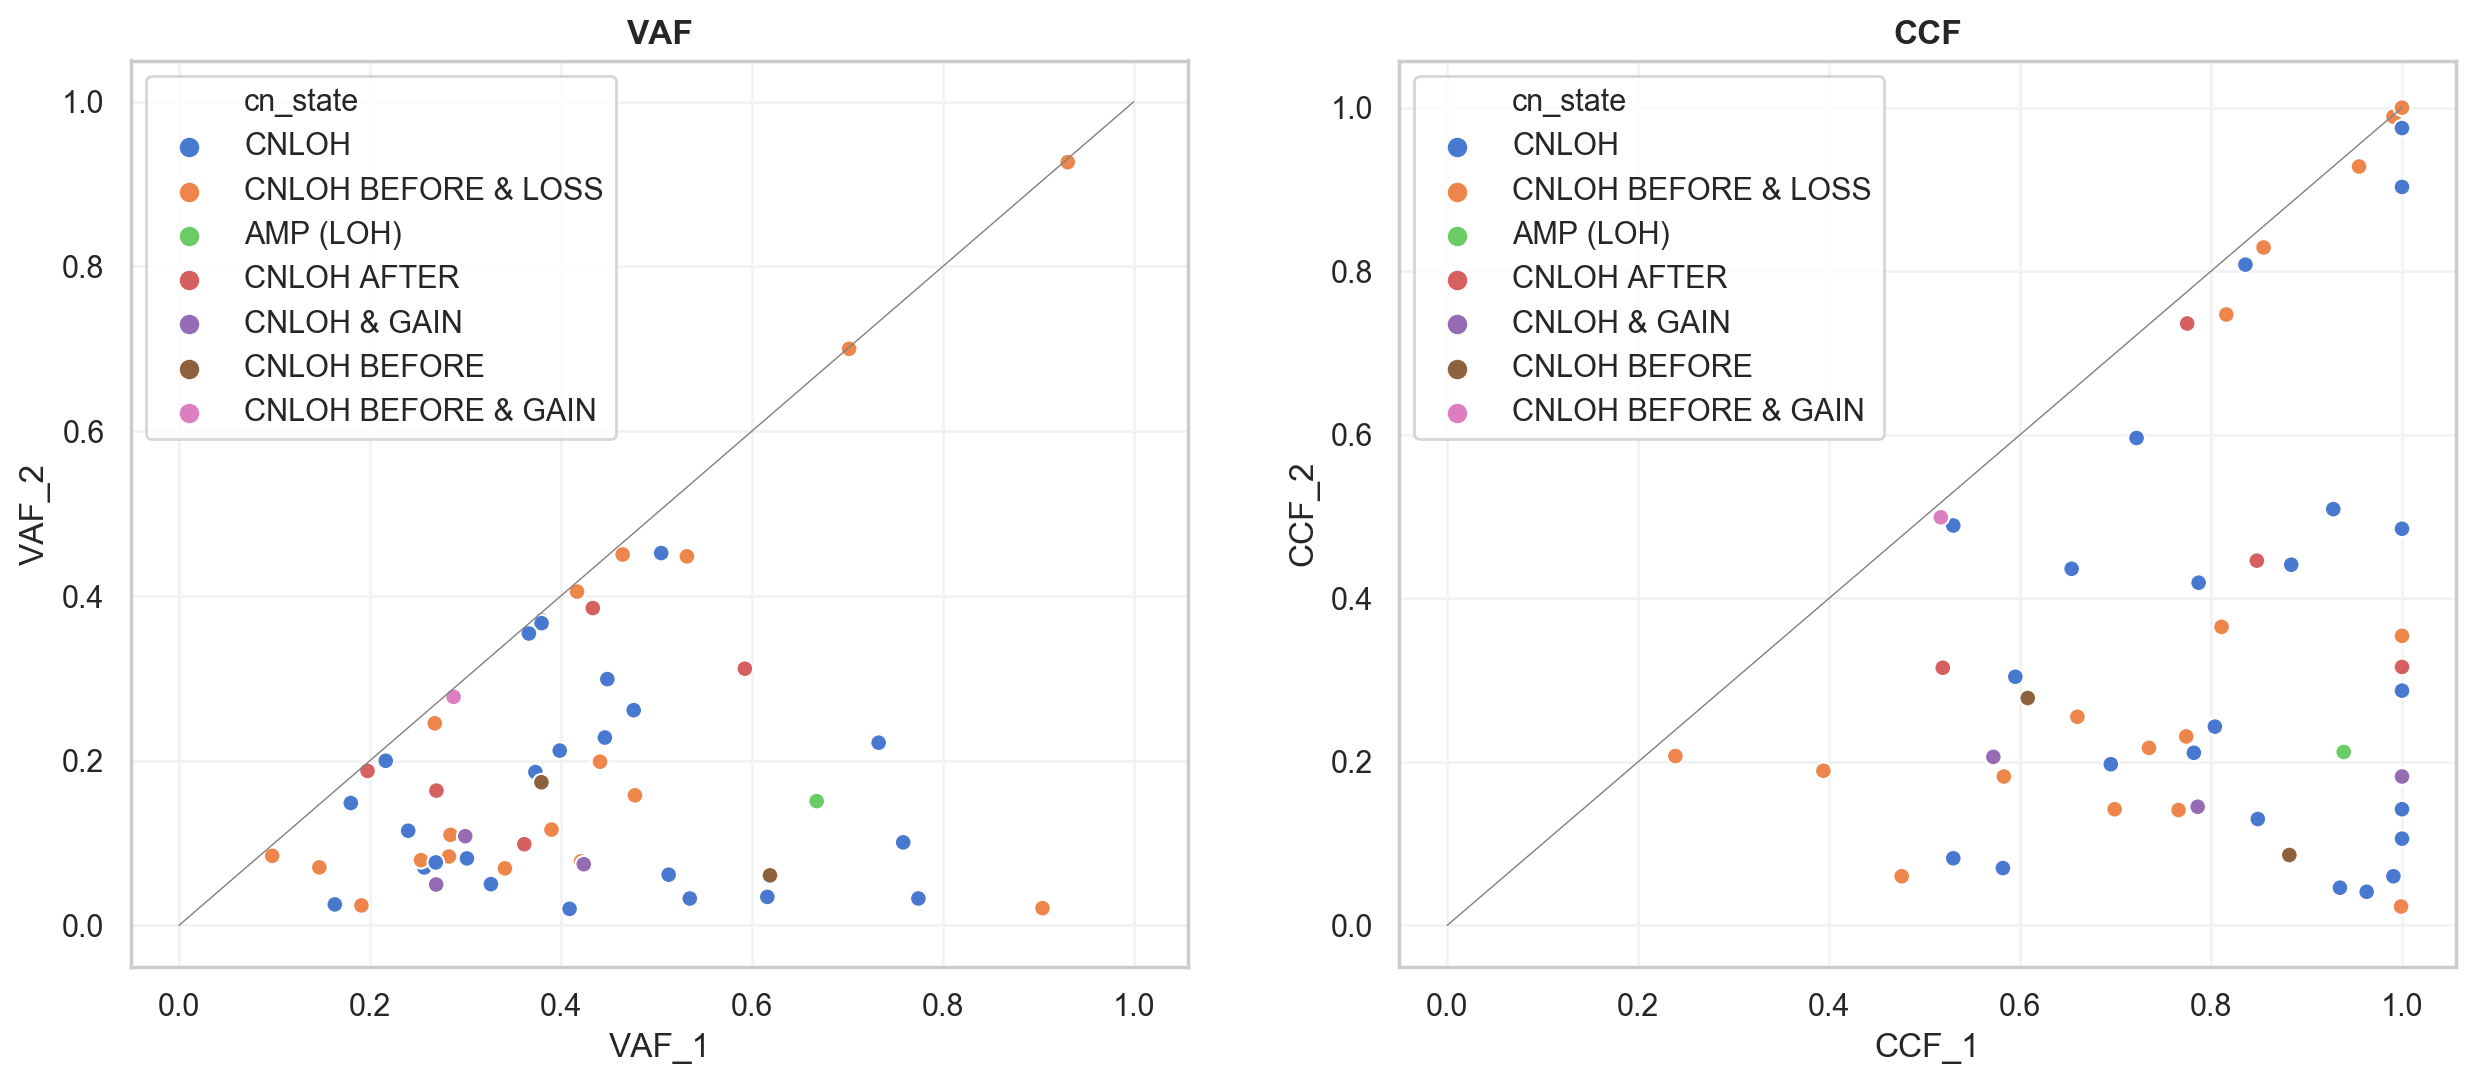

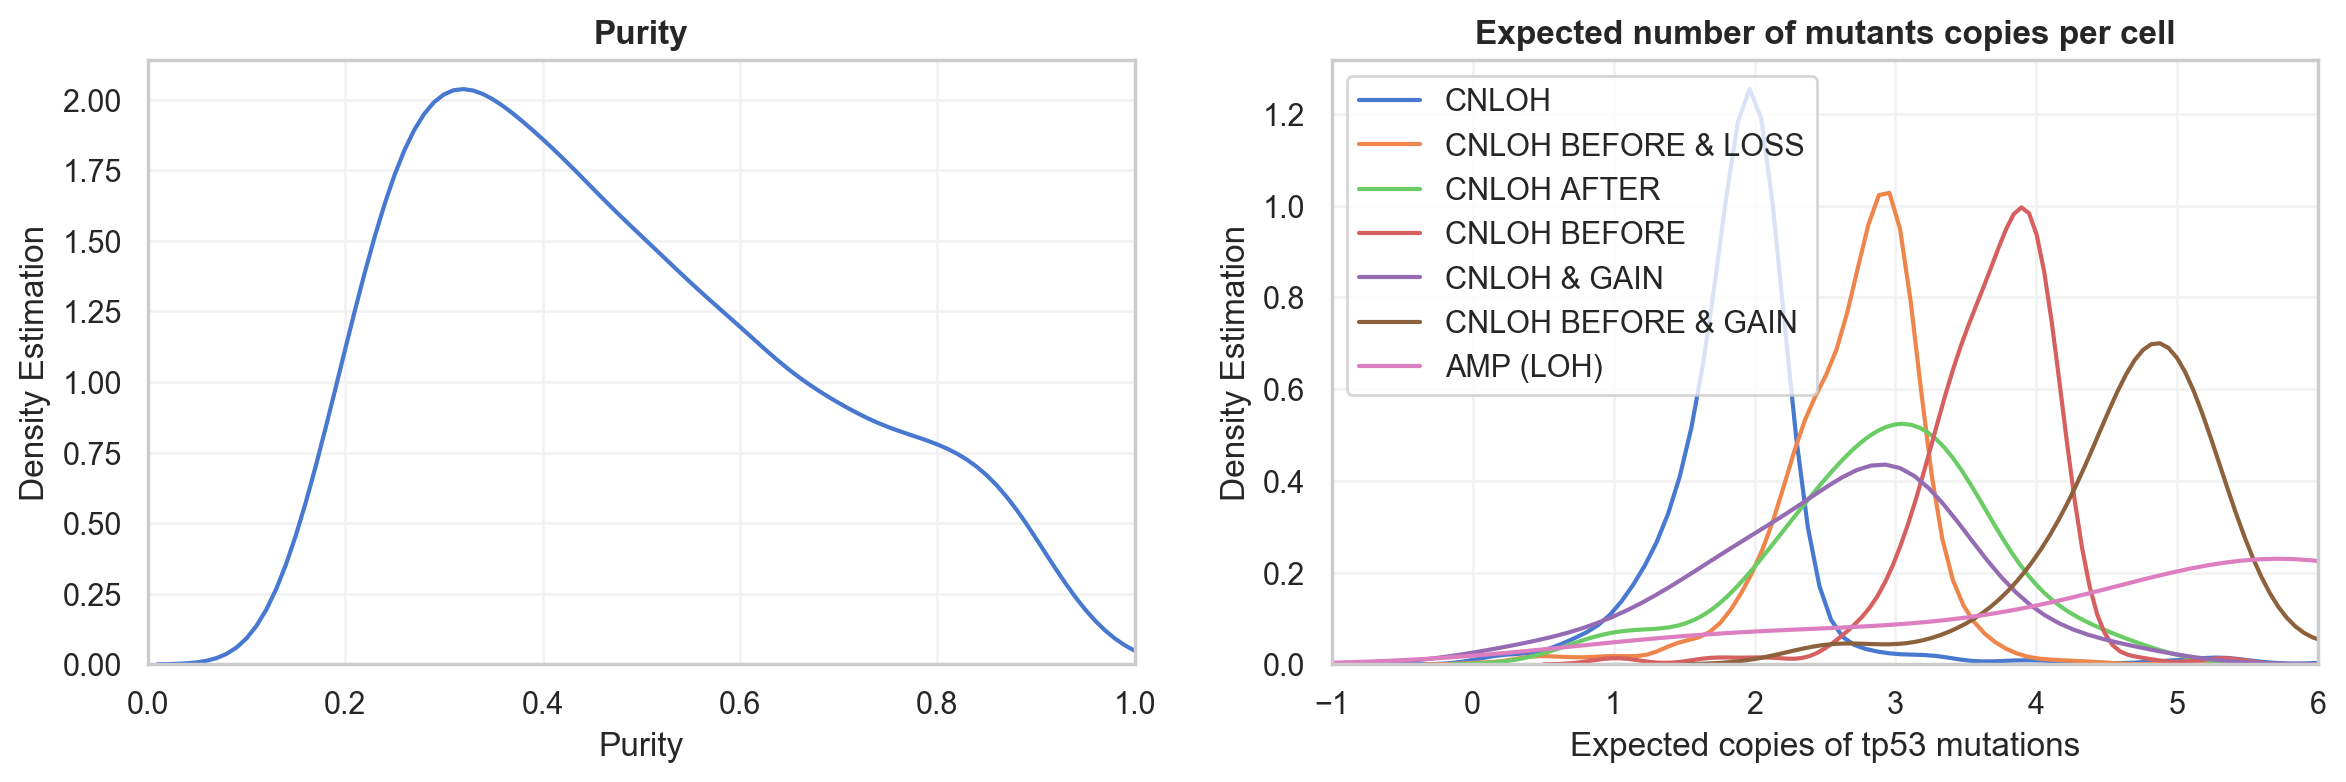

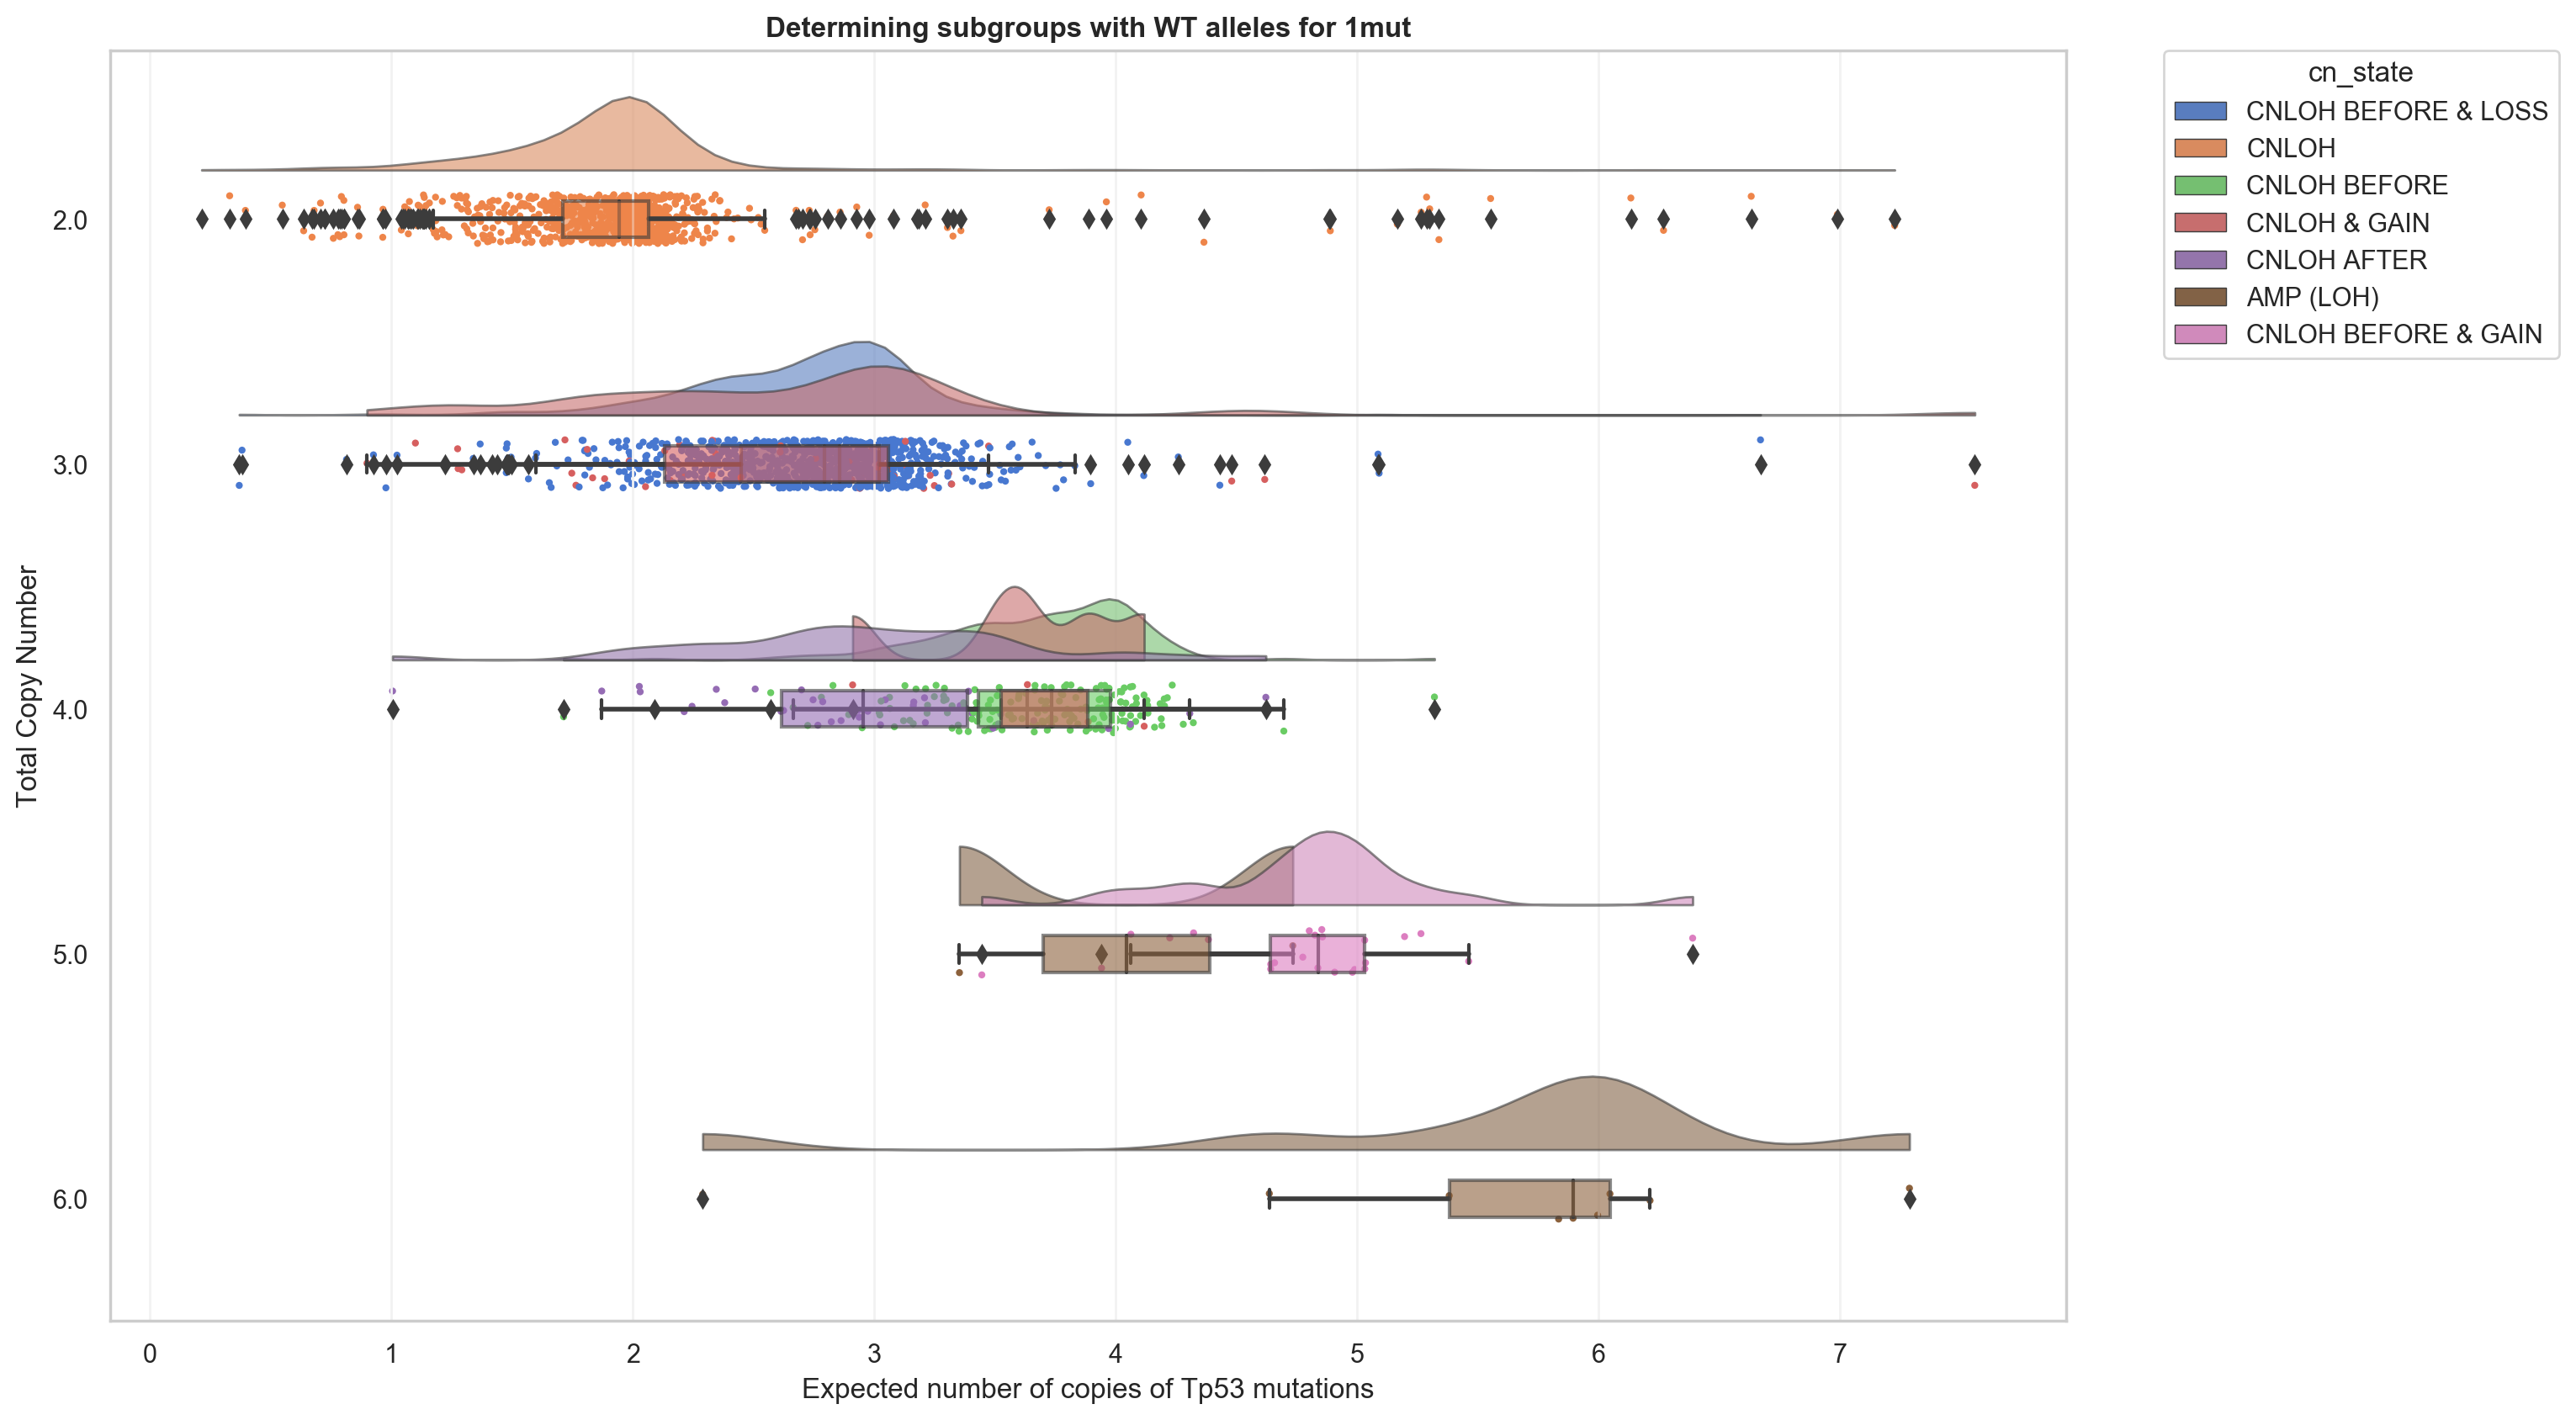

In [148]:
plot_summary(LOH,'LOH_noWT')

count
cn_state          
AMP             12
GAIN            91
LOSS & GAIN     15

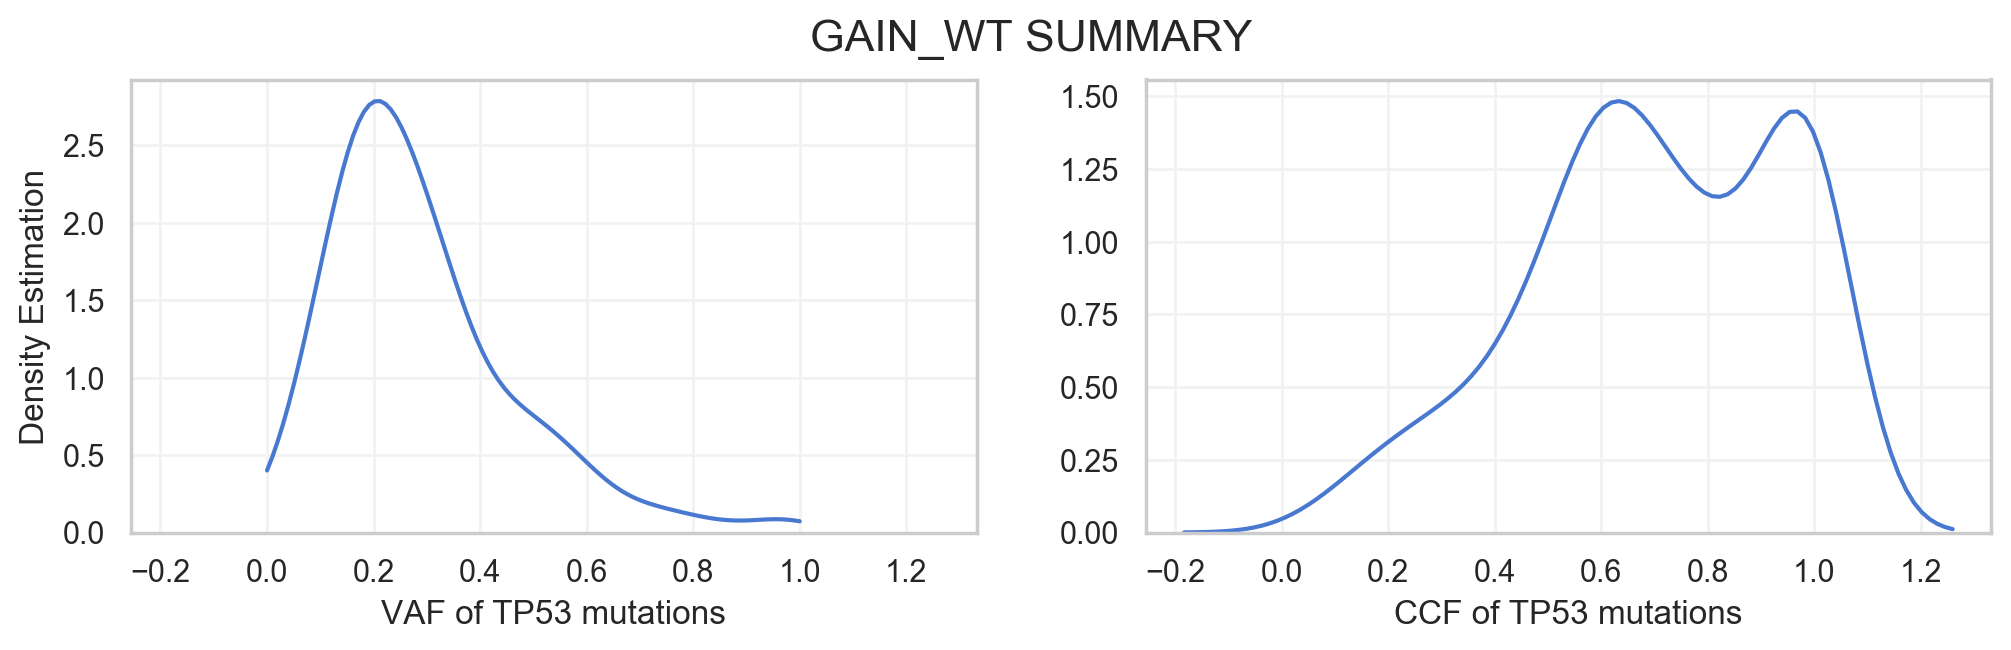

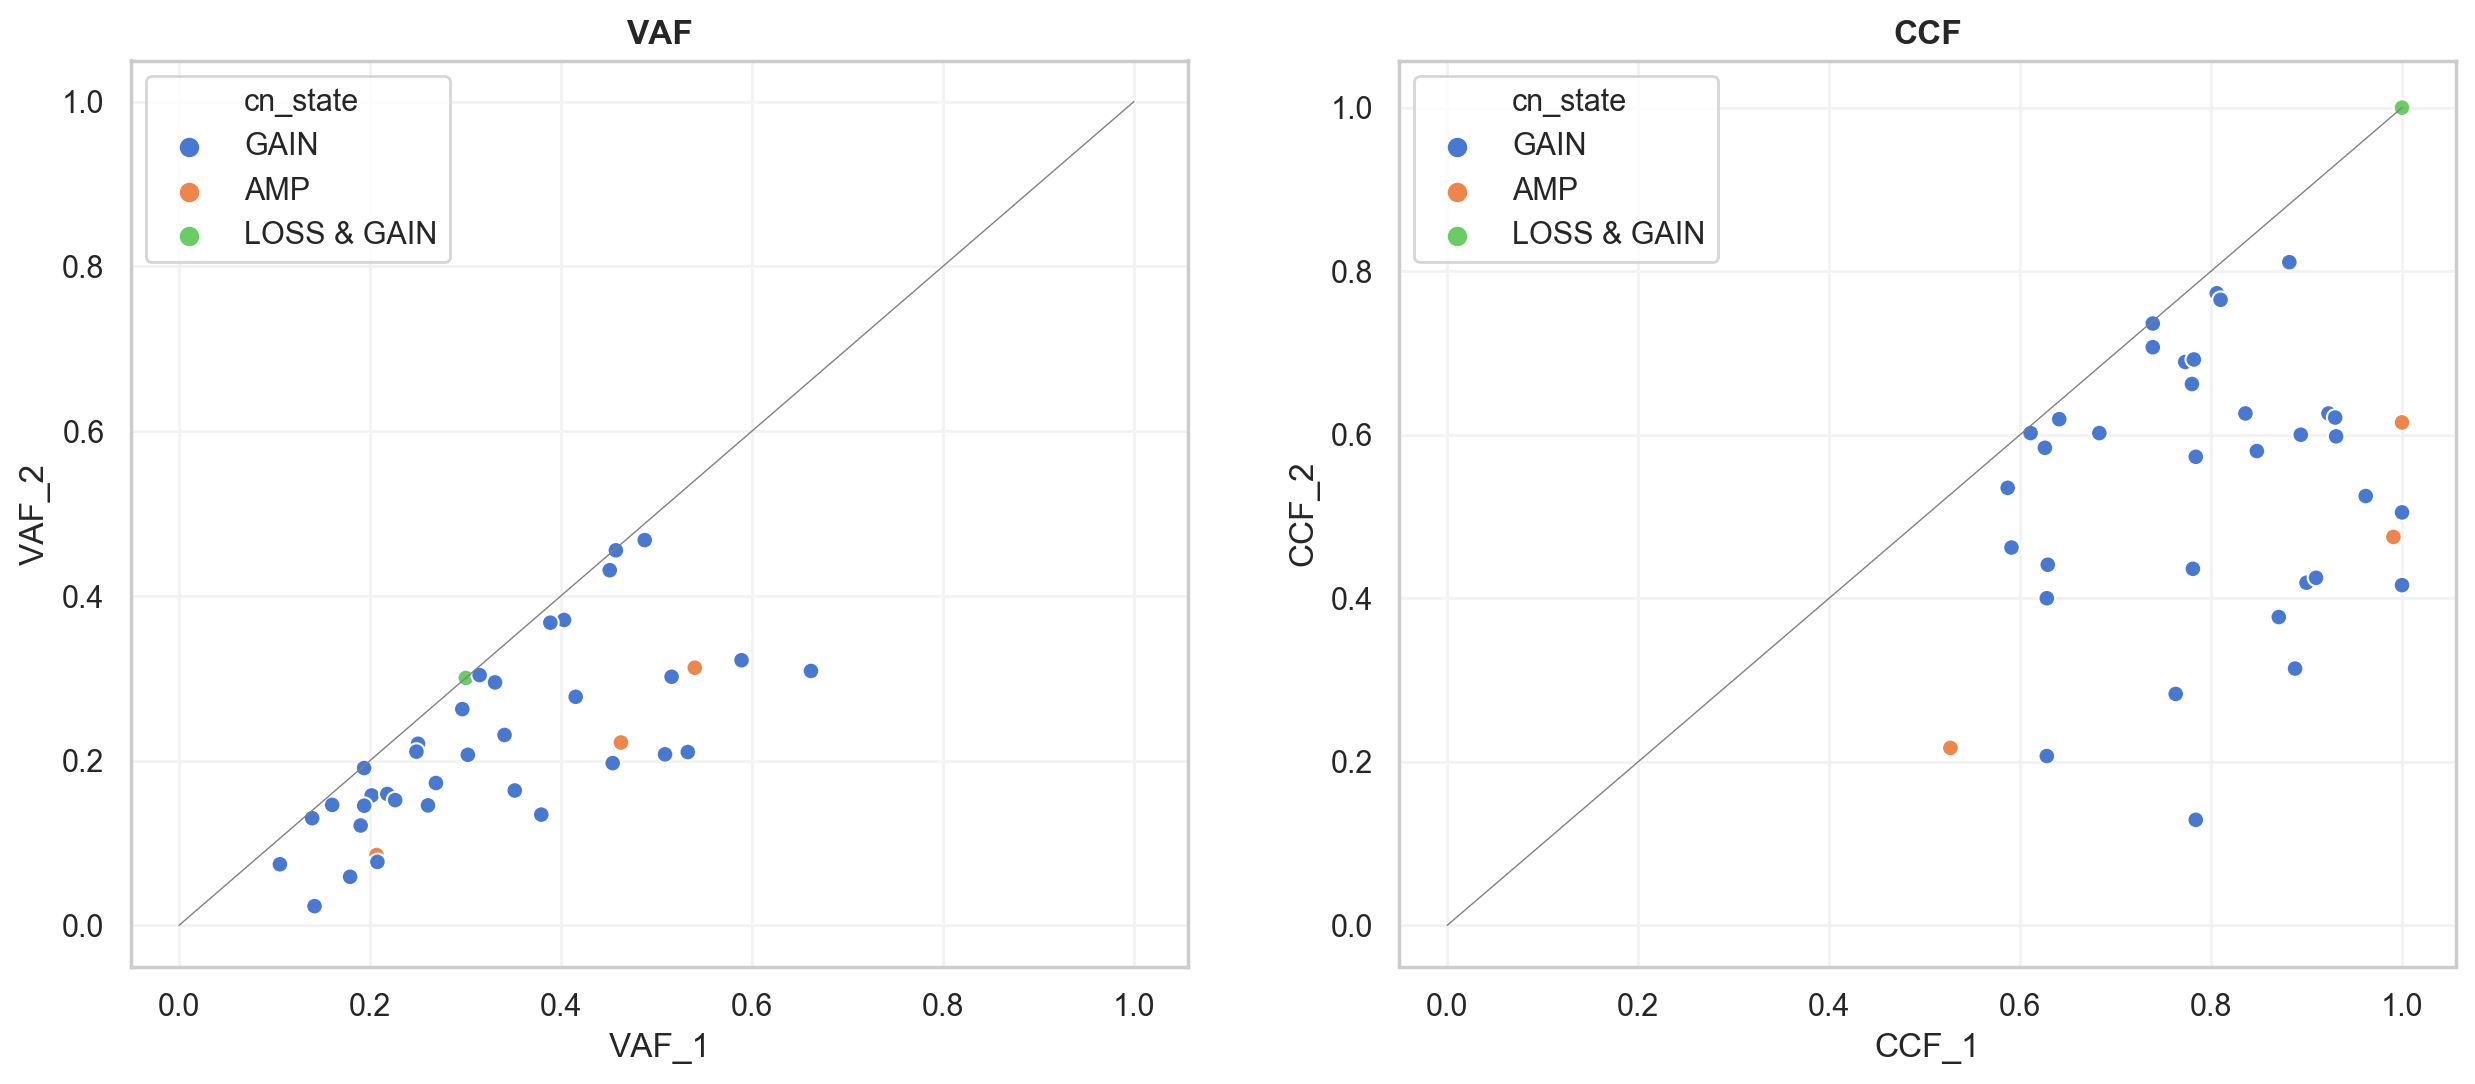

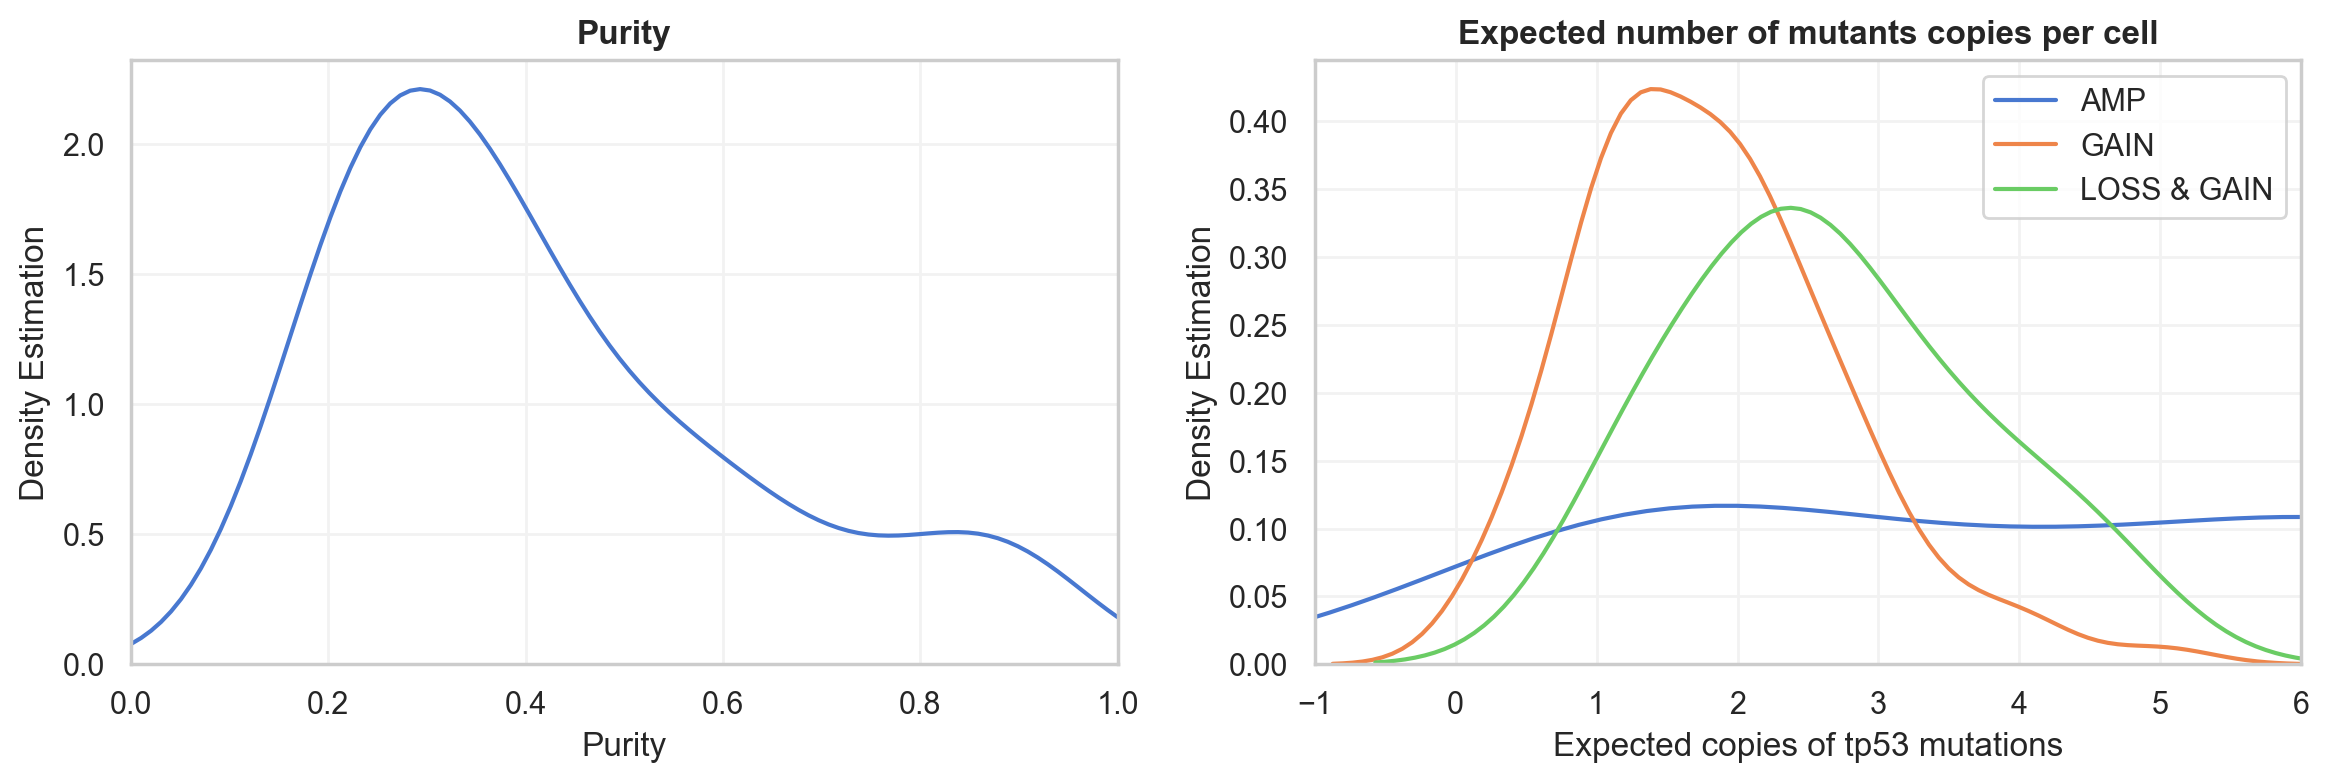

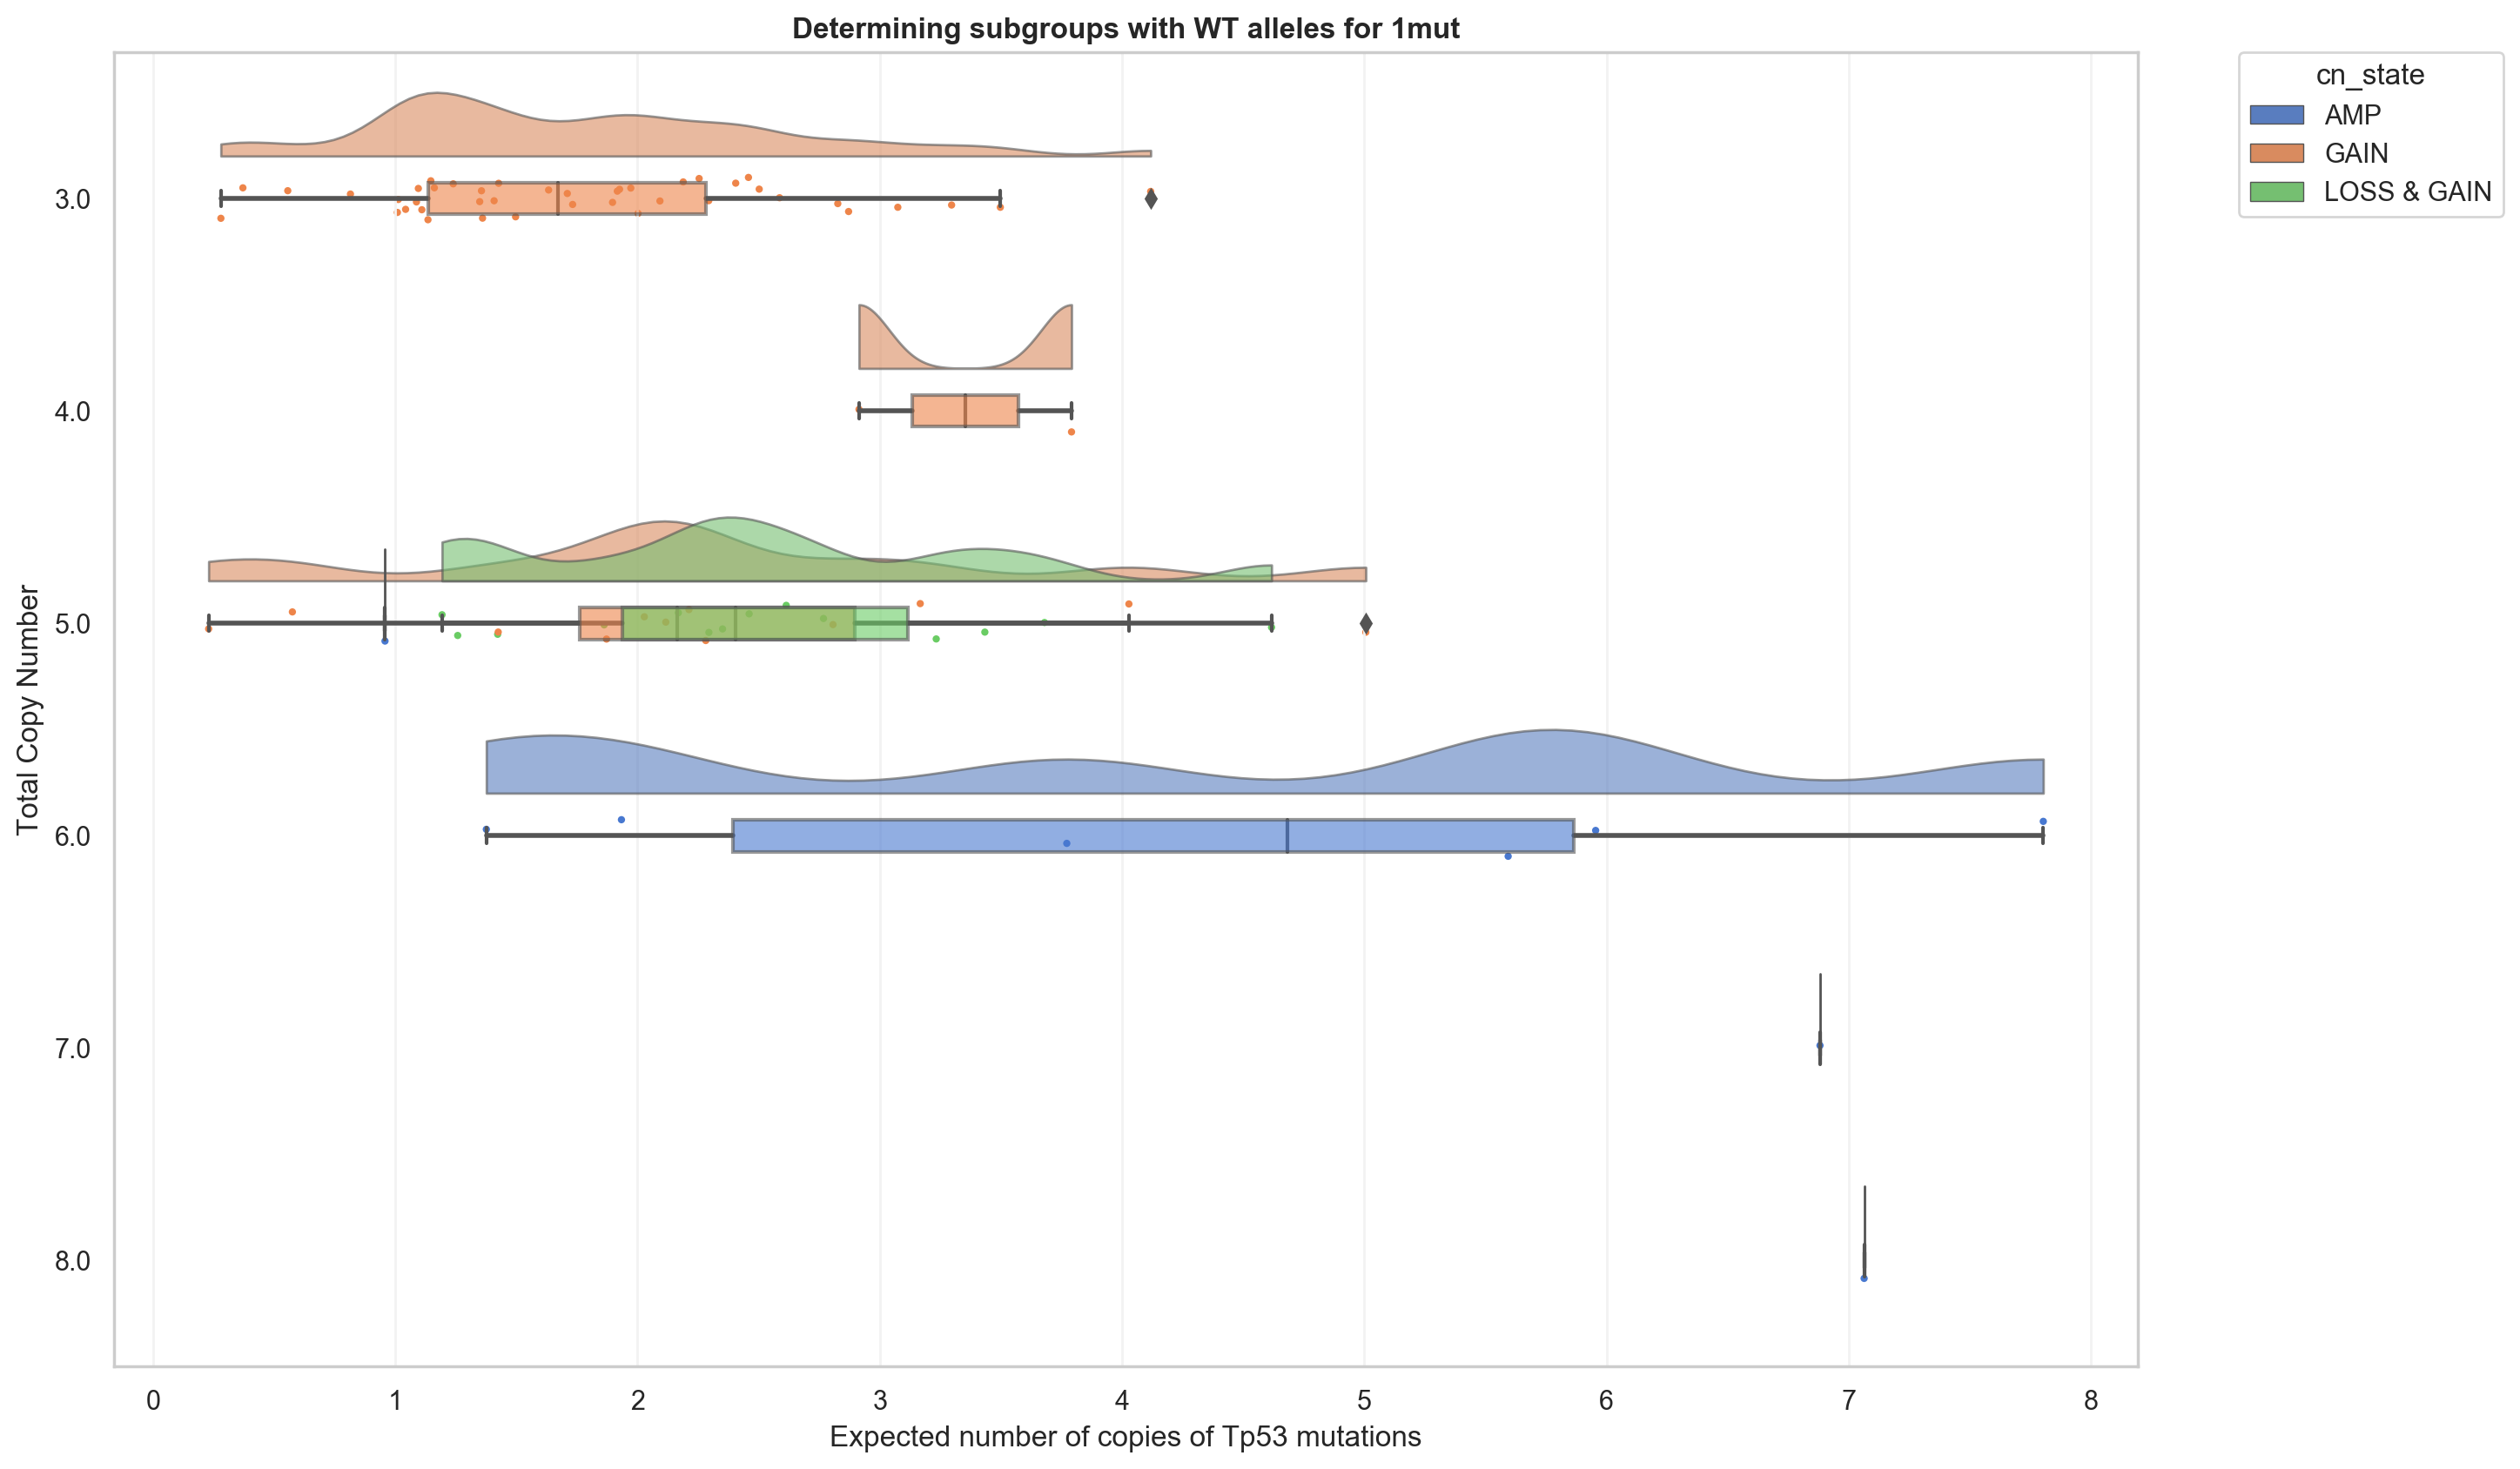

In [140]:
plot_summary(GAIN_WT,'GAIN_WT')

count
cn_state                
CNLOH AFTER           43
DOUBLE LOSS AFTER    149

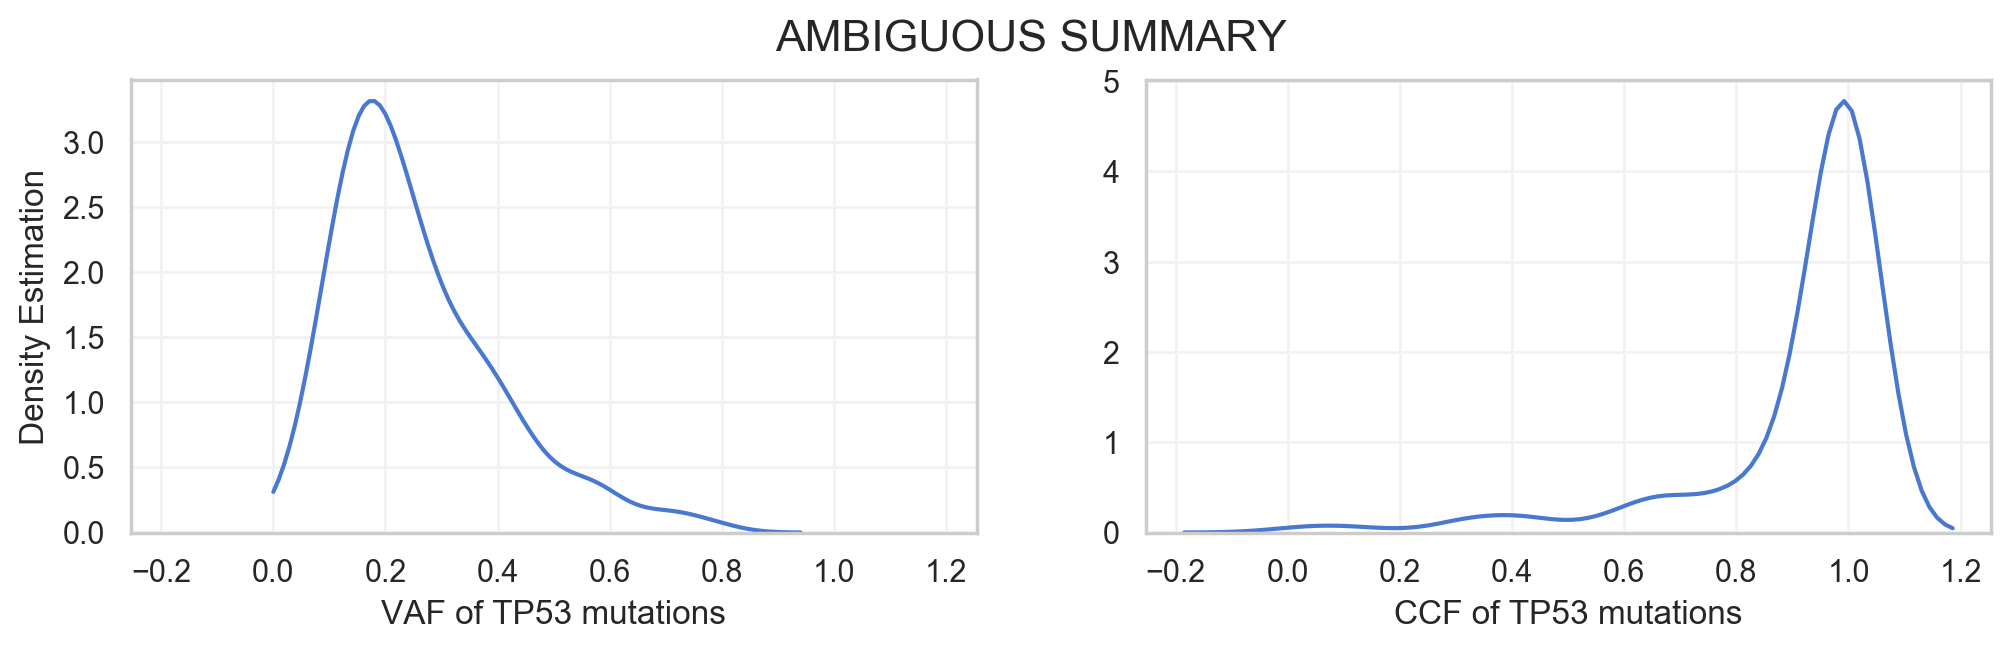

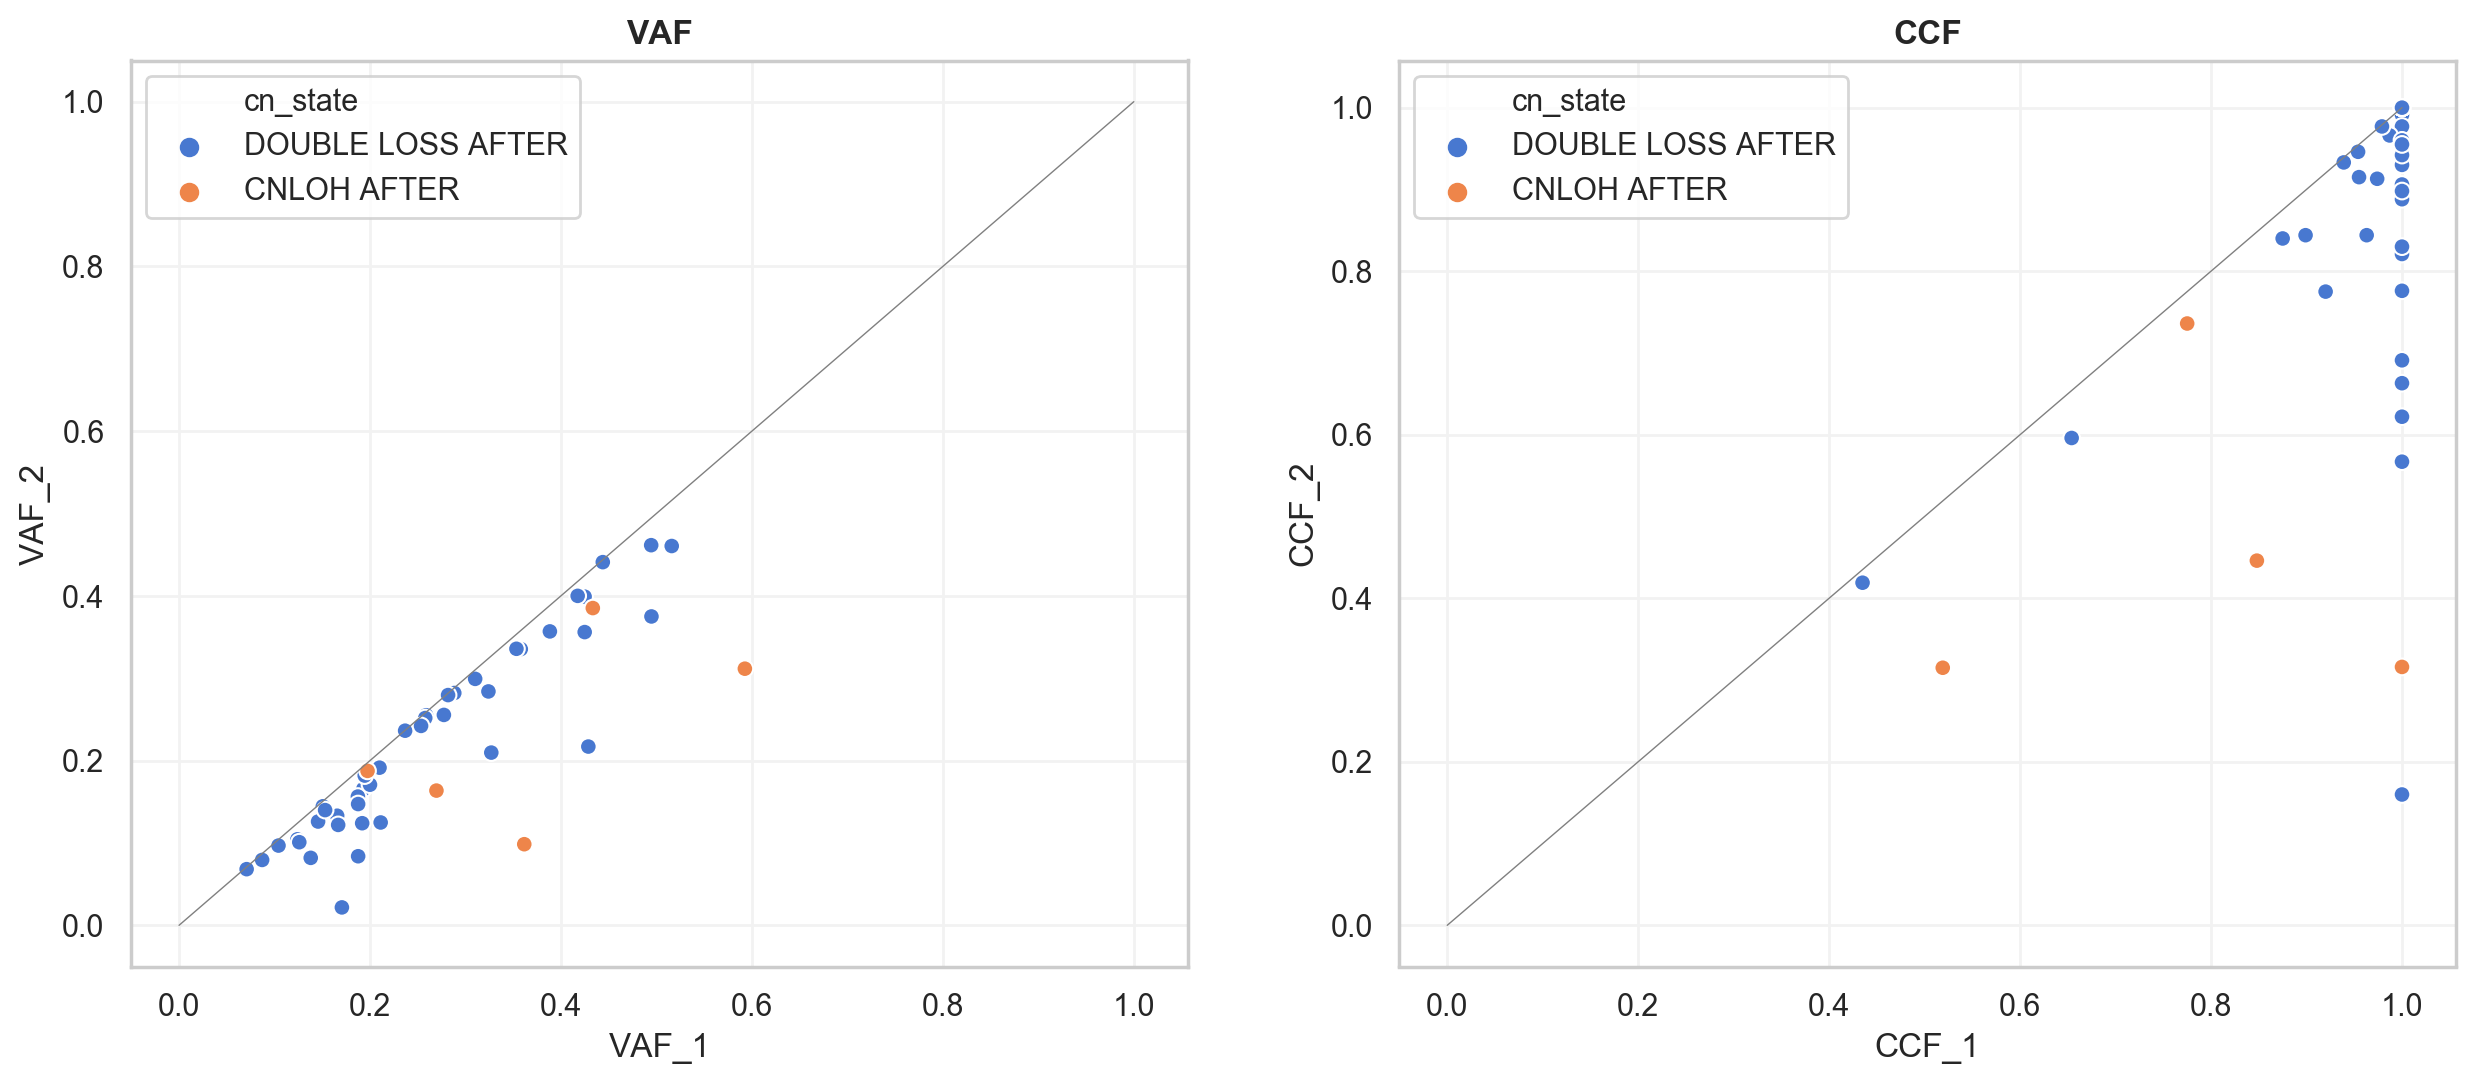

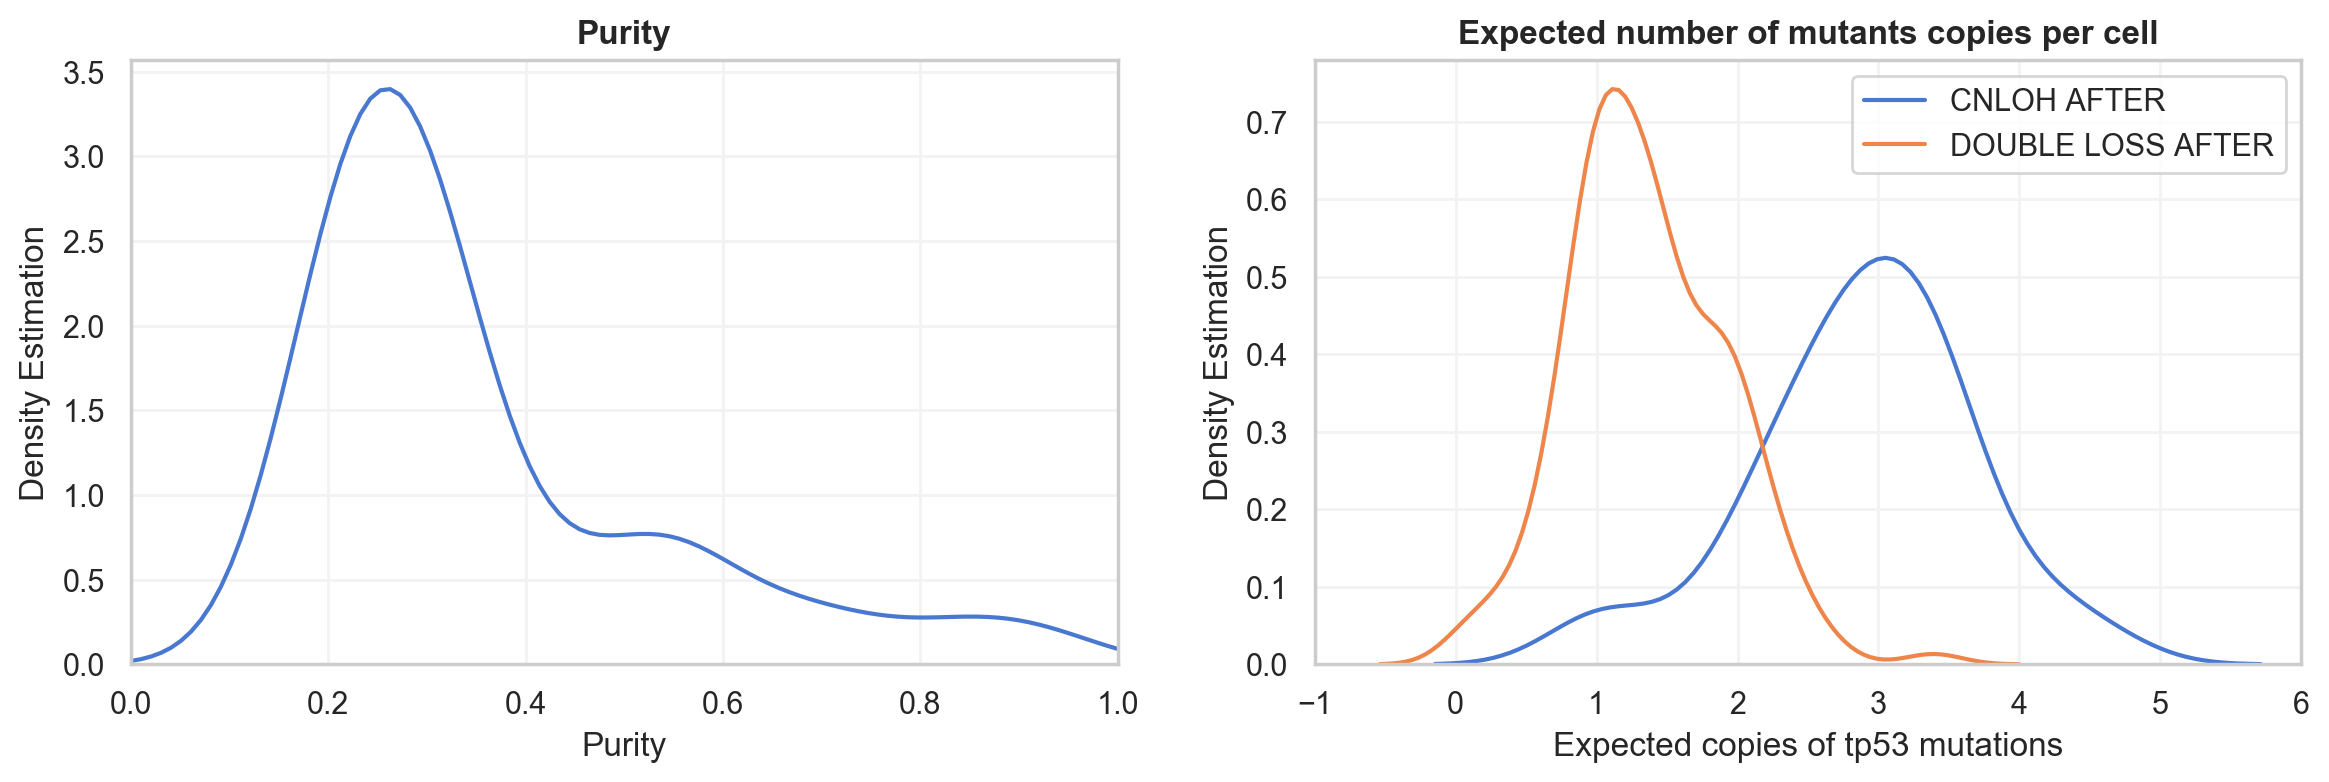

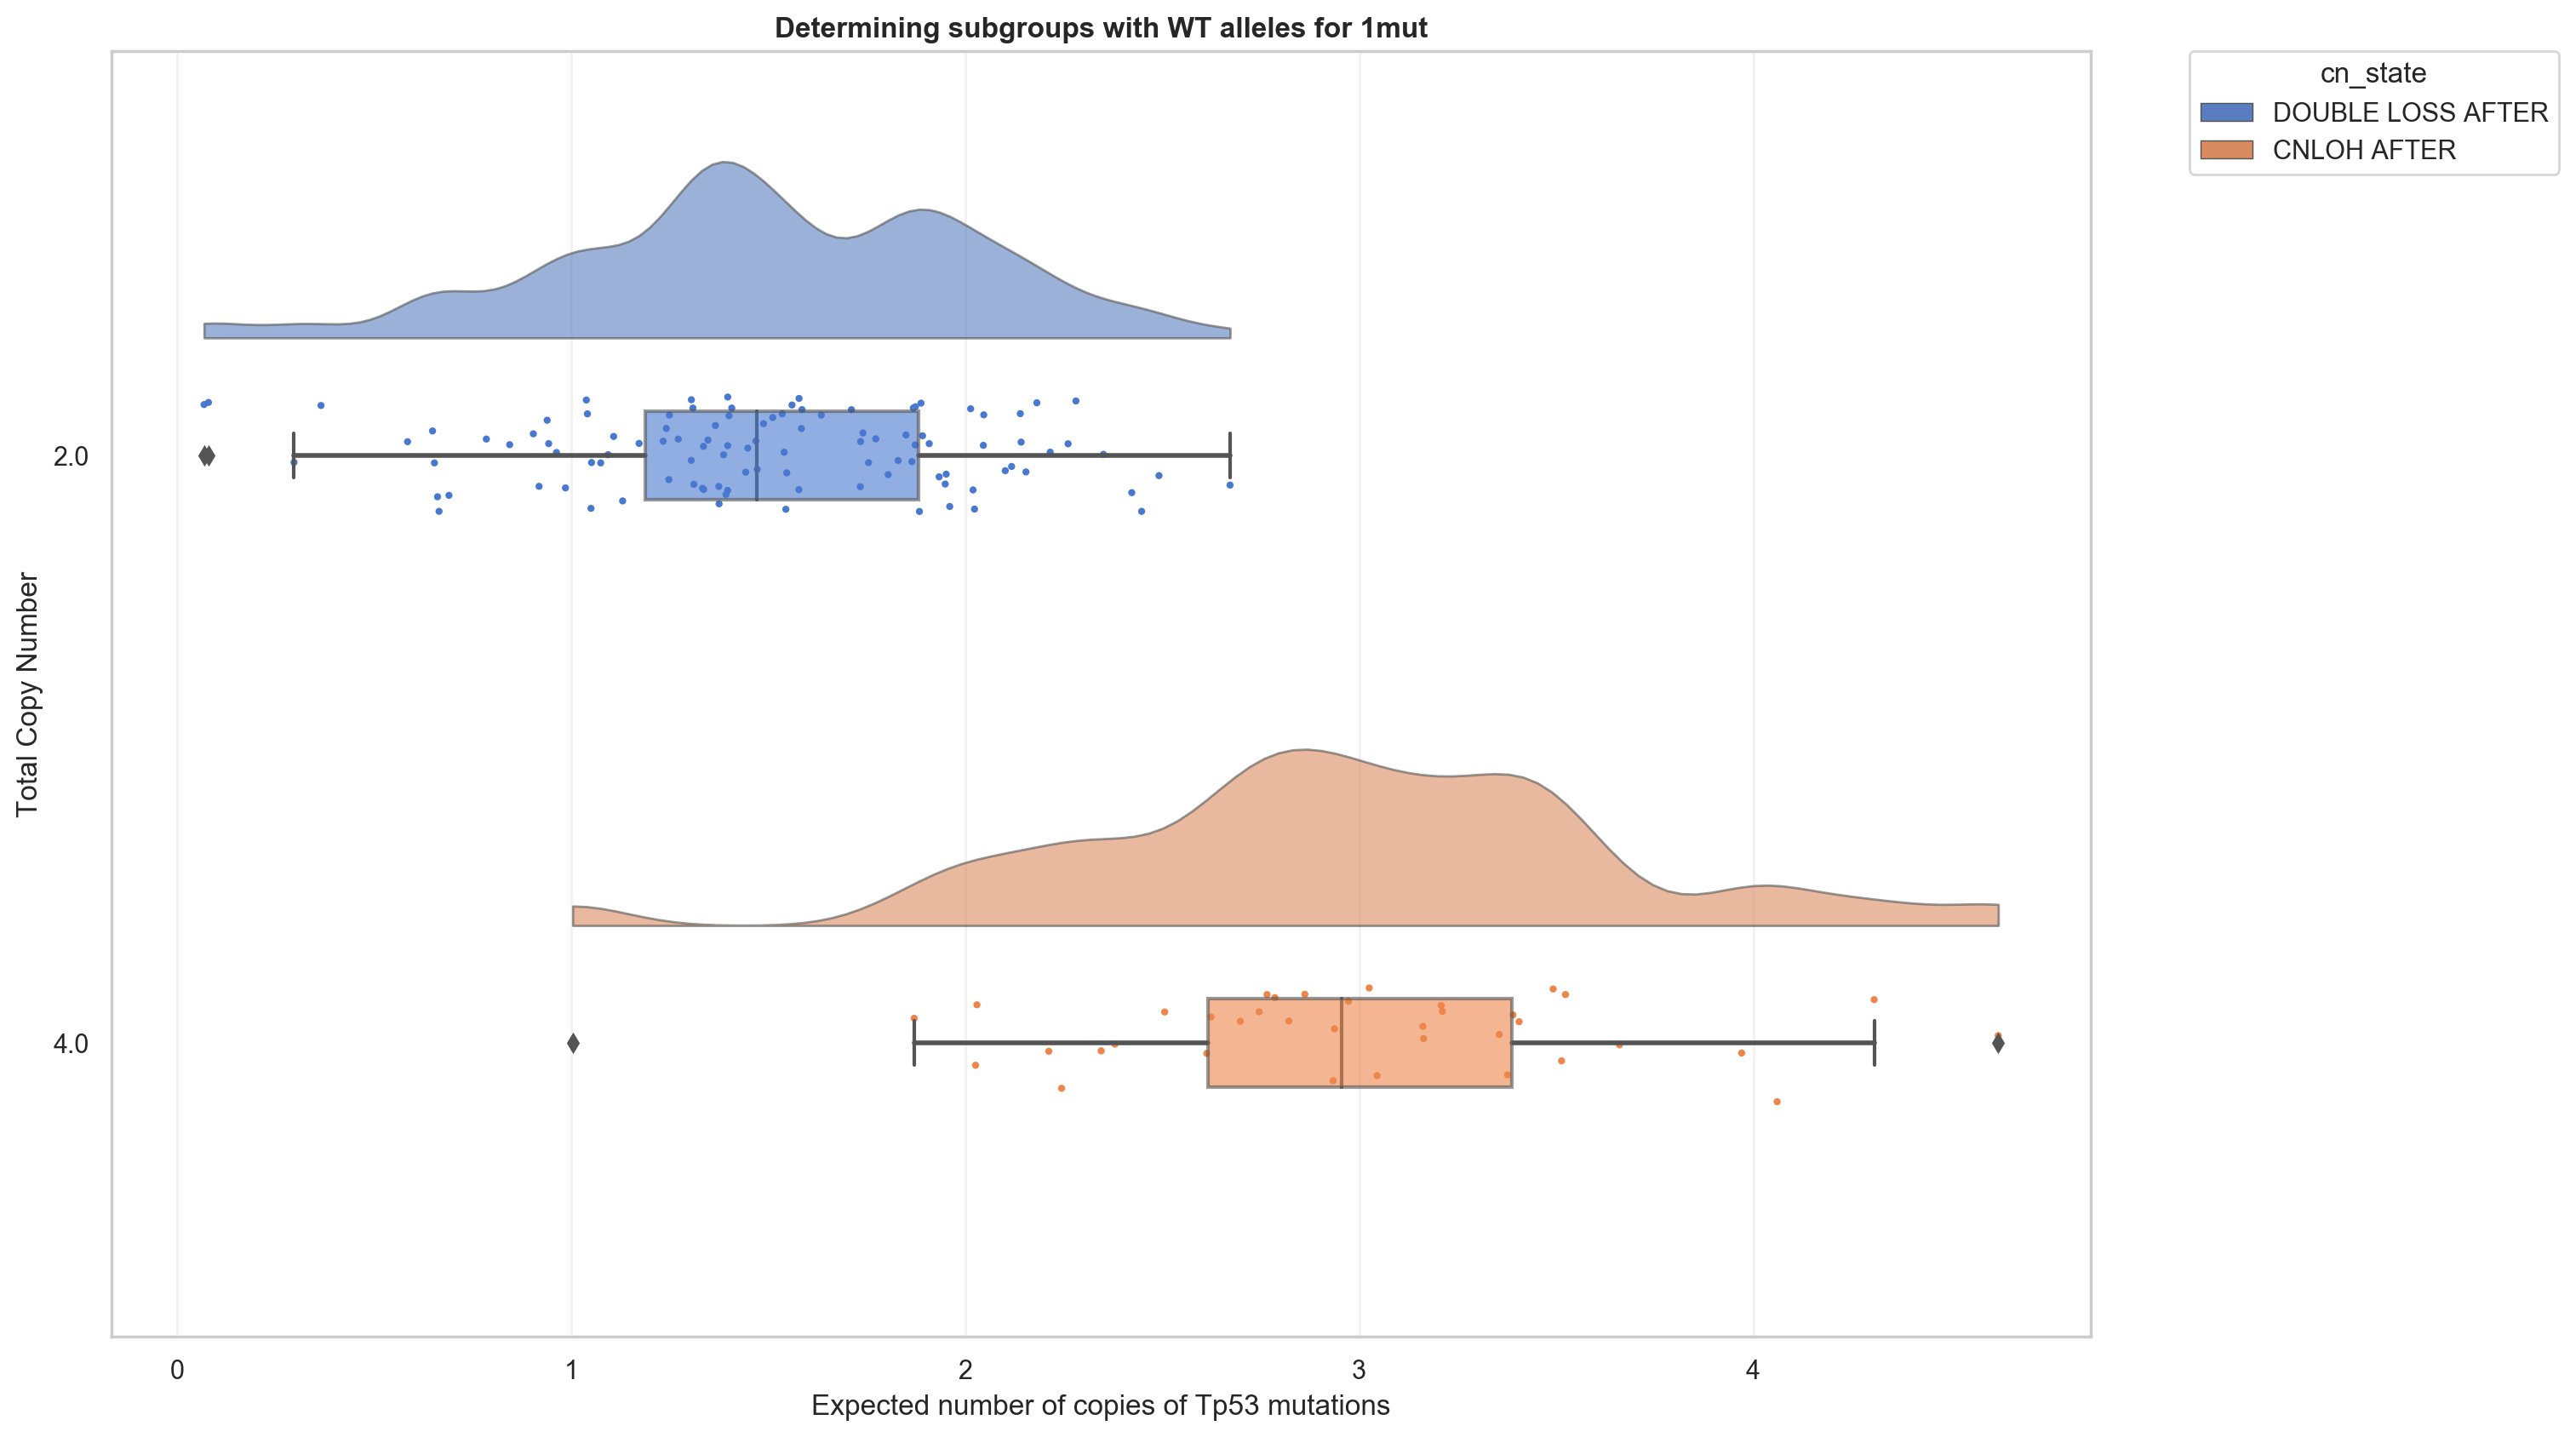

In [142]:
plot_summary(AMBIGUOUS,'AMBIGUOUS')

count
cn_state             
AMP (BALANCED)      4
AMP (LOH)          12
HOMDEL             71

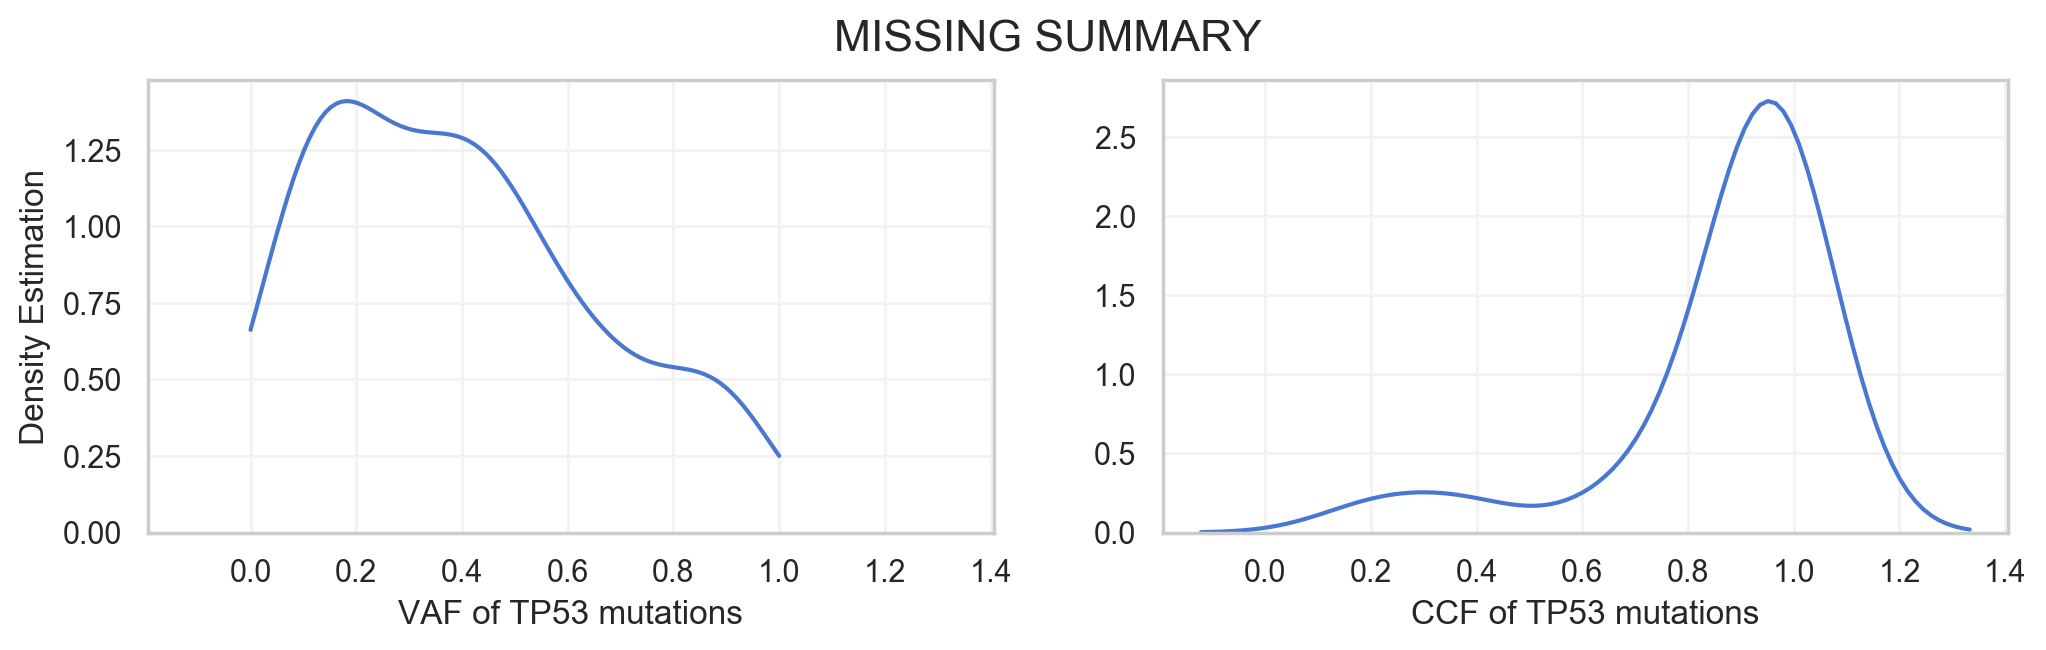

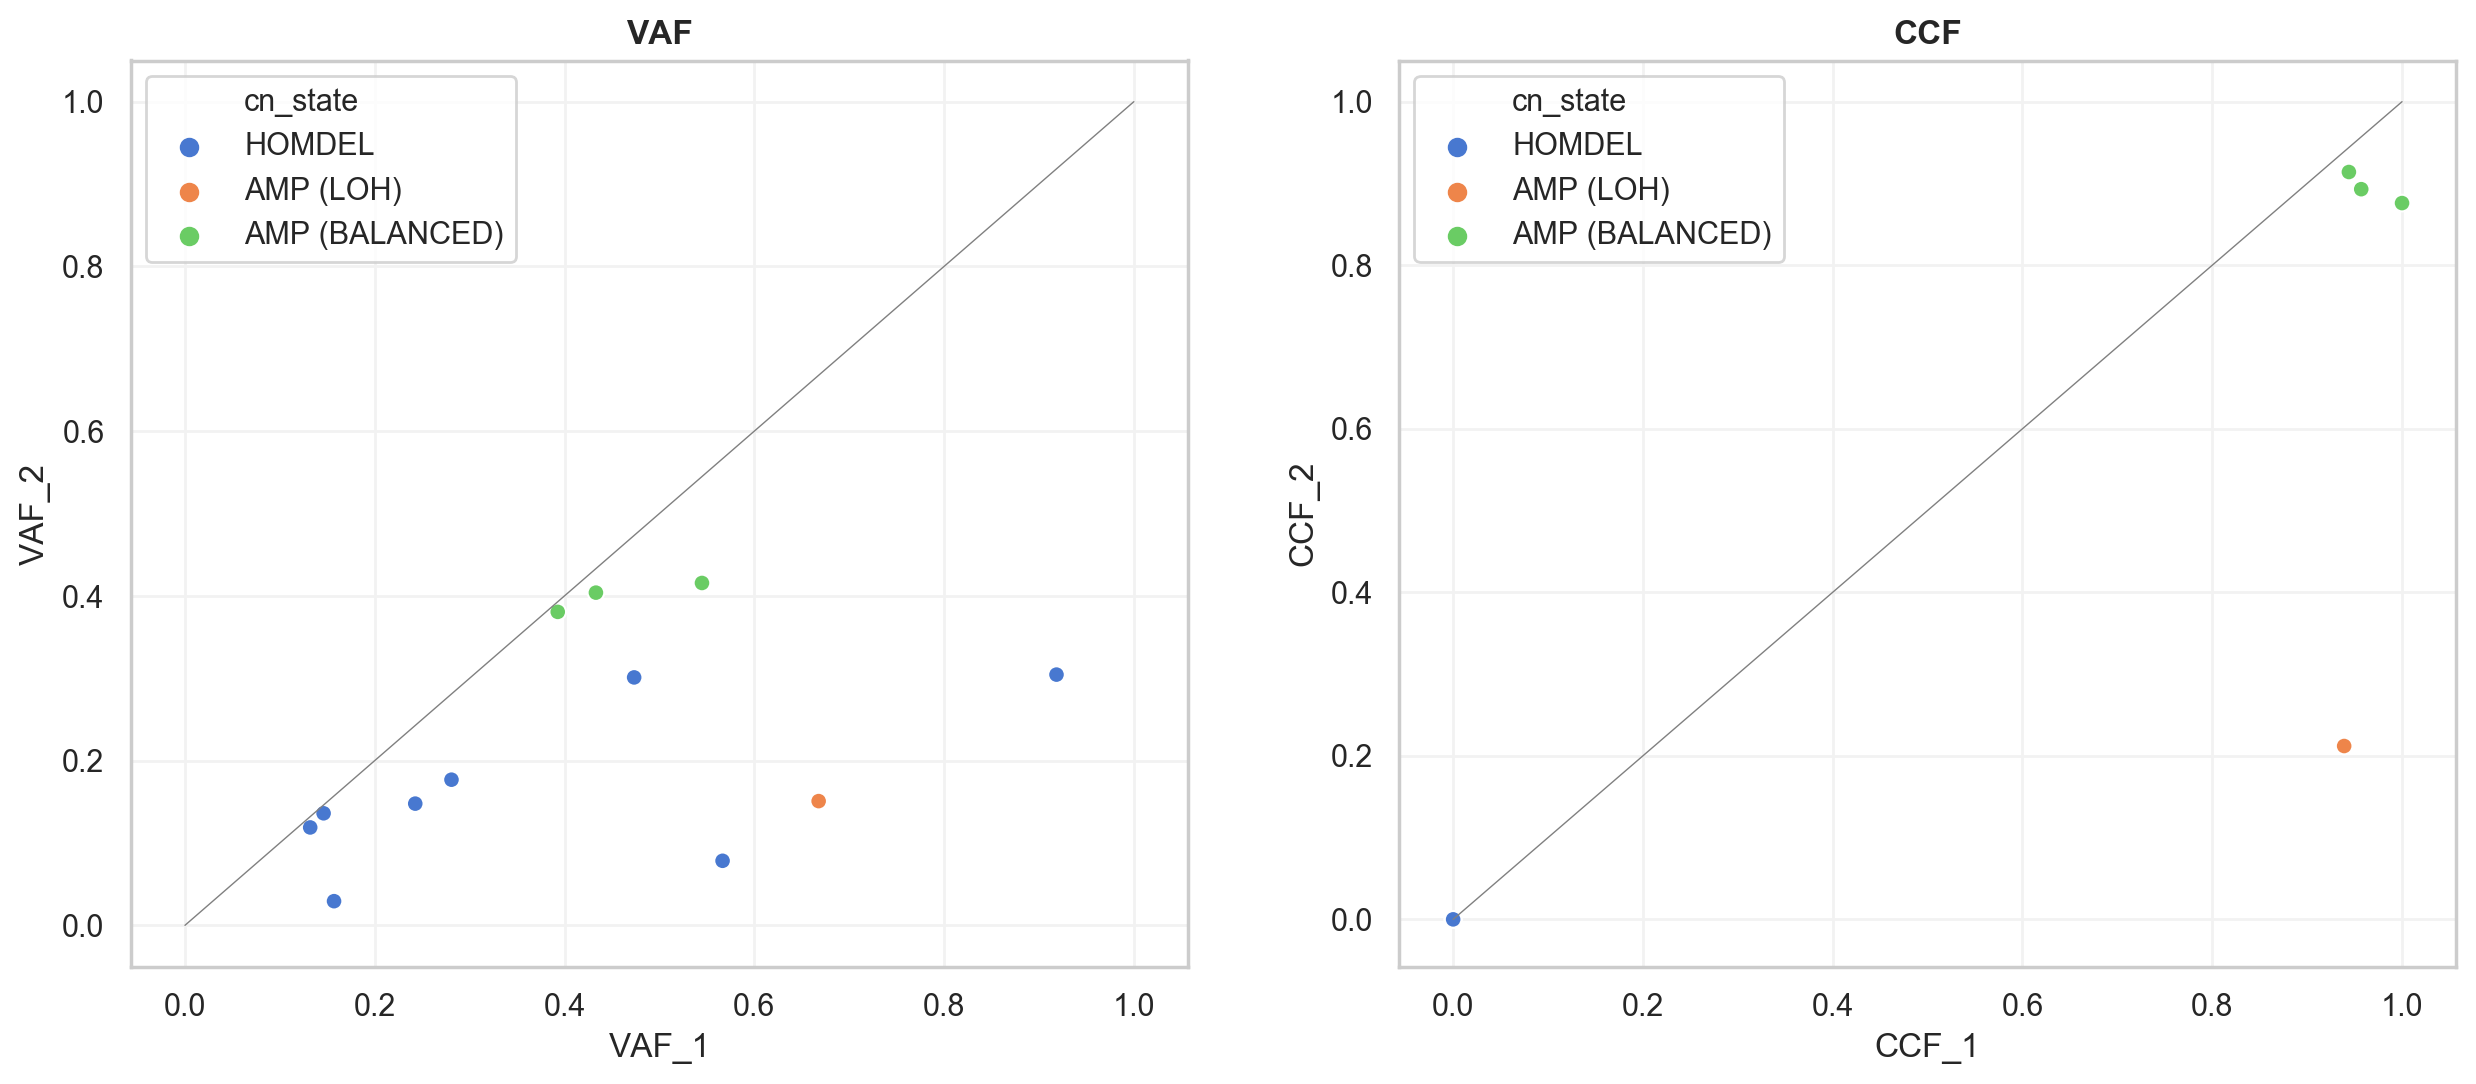

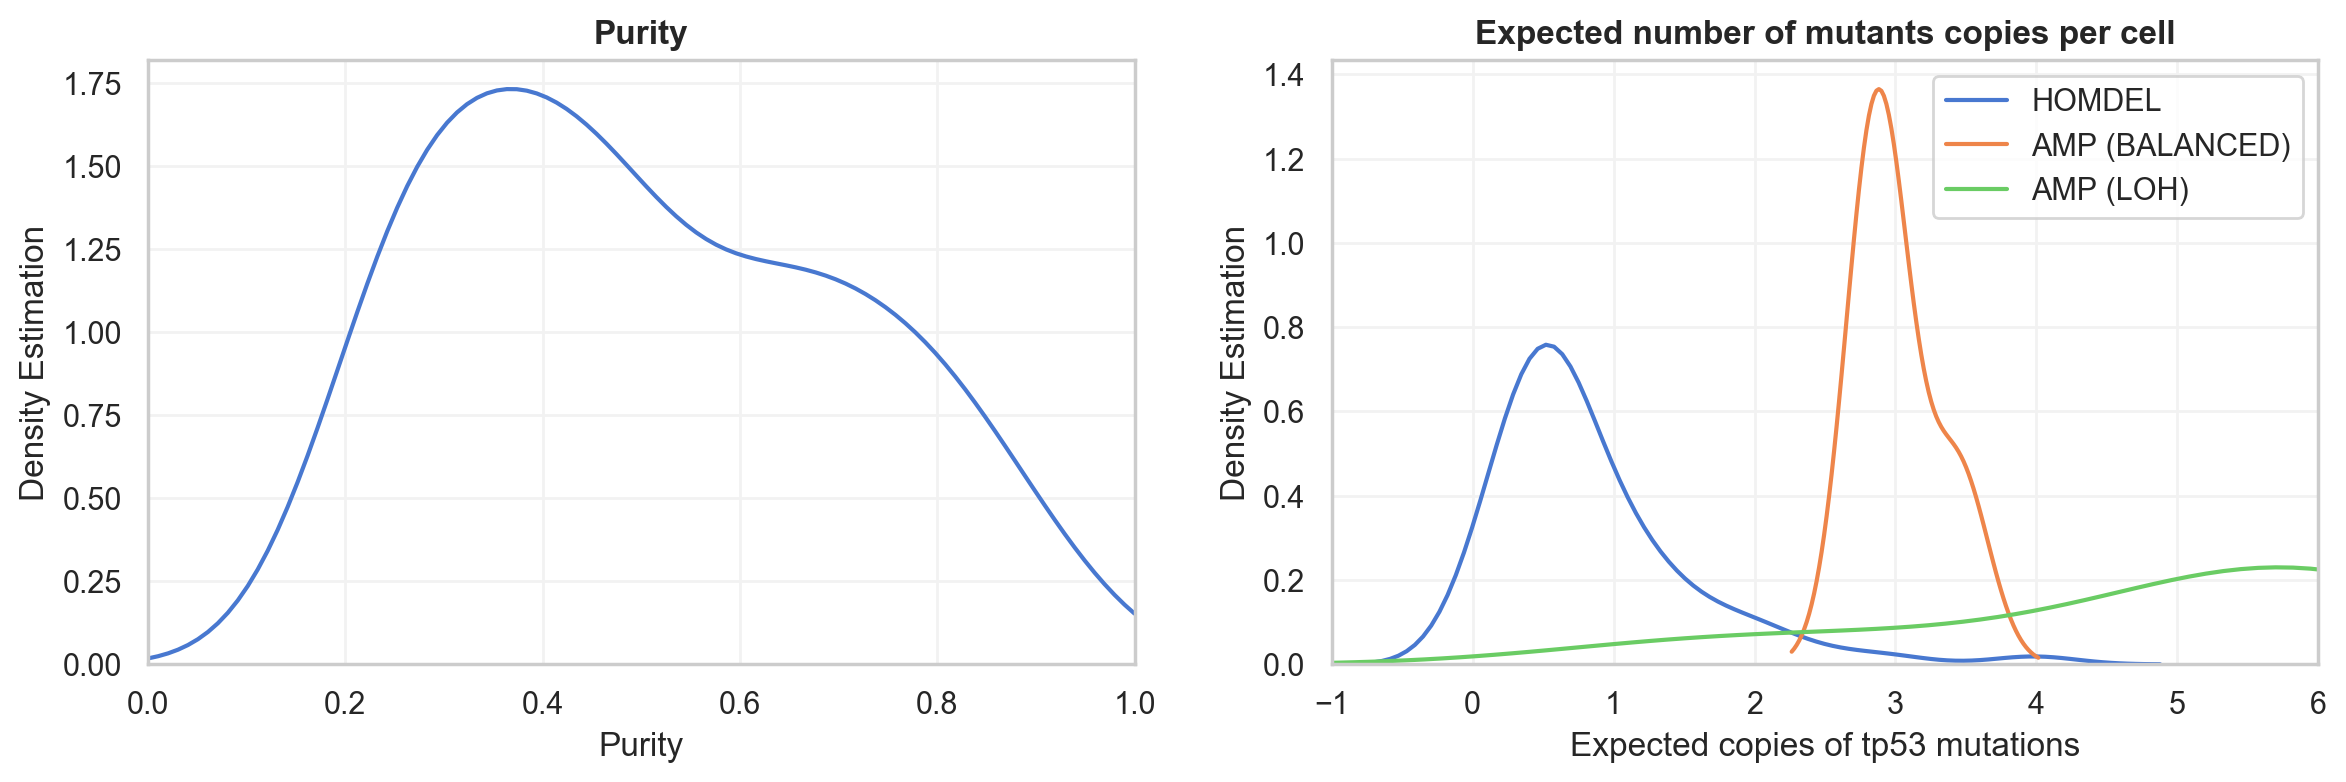

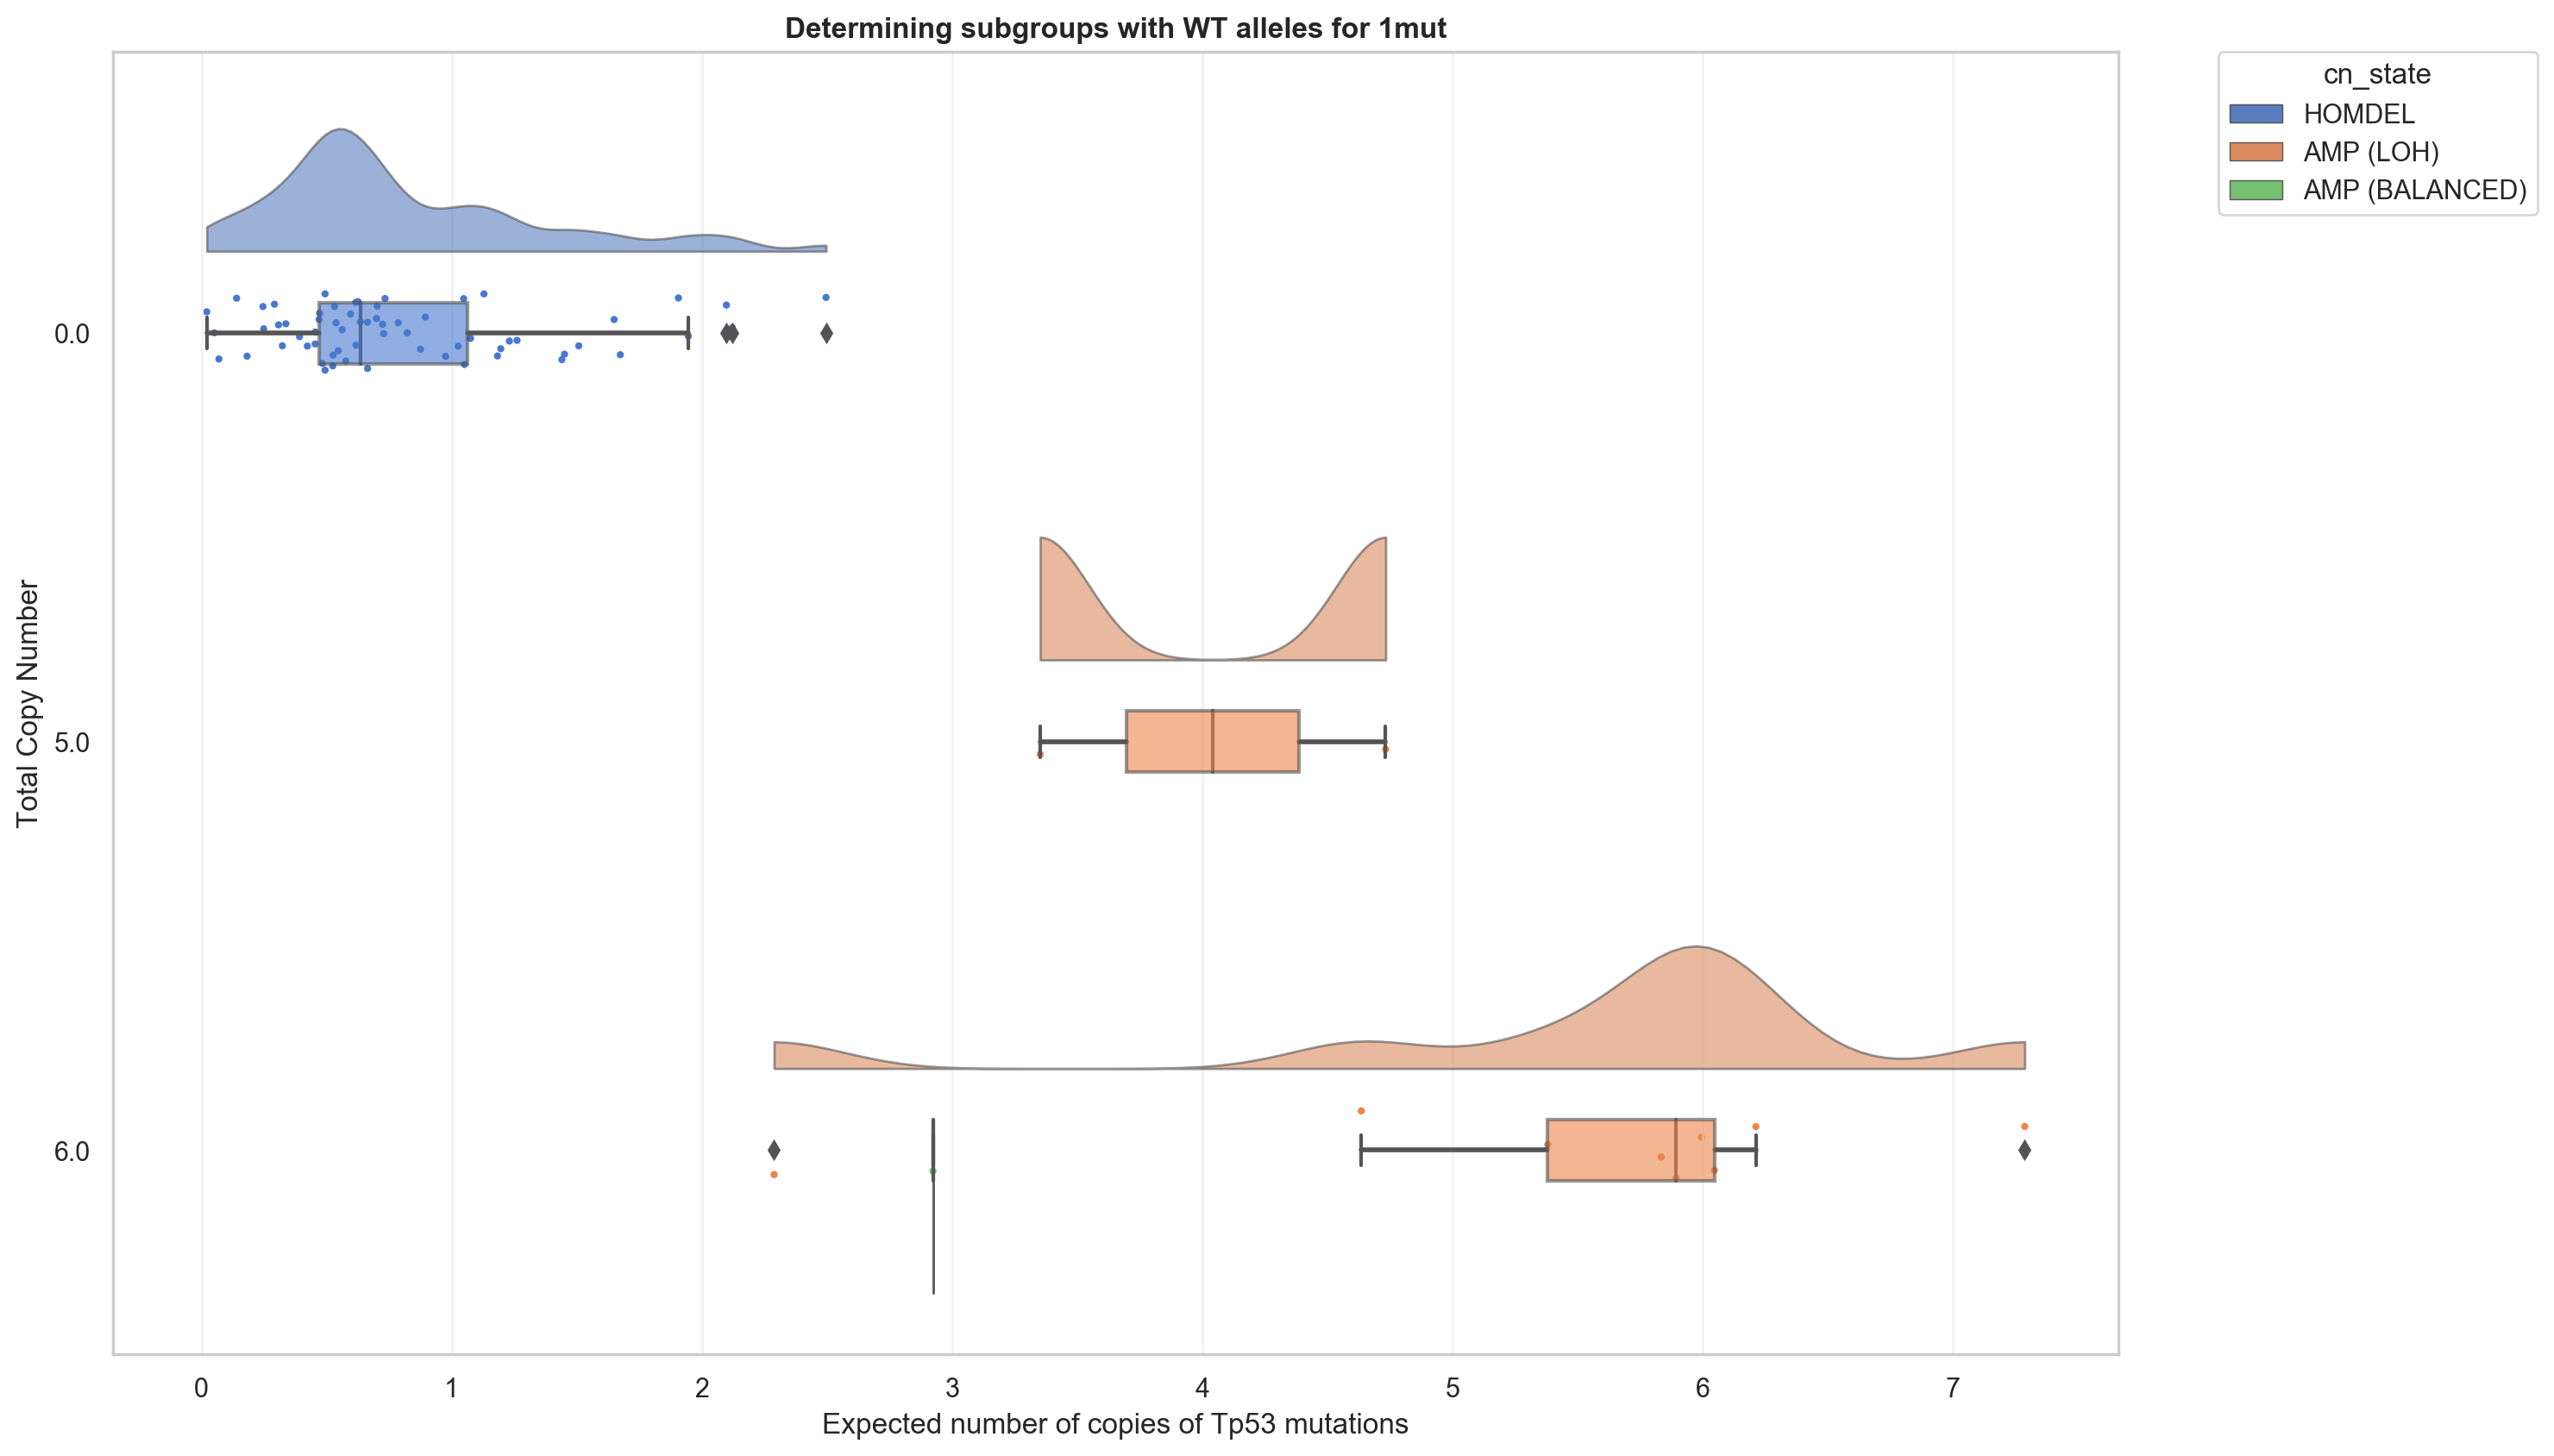

In [141]:
plot_summary(MISSING,'MISSING')

In [74]:
master_density = filter_muts(master, [1,2,3])
#data = master_density[master_density['wgd'] == 1]
pd.DataFrame(get_groupby(master_density, 'cn_state','count')).sort_values(by='count')

count
cn_state                  
AMP (BALANCED)           4
AMP                     12
AMP (LOH)               12
LOSS & GAIN             15
CNLOH BEFORE & GAIN     26
CNLOH AFTER             43
CNLOH & GAIN            61
HOMDEL                  71
TETRAPLOID              82
GAIN                    91
DOUBLE LOSS AFTER      149
CNLOH BEFORE           174
LOSS BEFORE & AFTER    226
LOSS AFTER             271
CNLOH                  802
CNLOH BEFORE & LOSS    893
INDETERMINATE         1207
DIPLOID               1711
LOSS BEFORE           3131
HETLOSS               3727

---
## Group Analysis

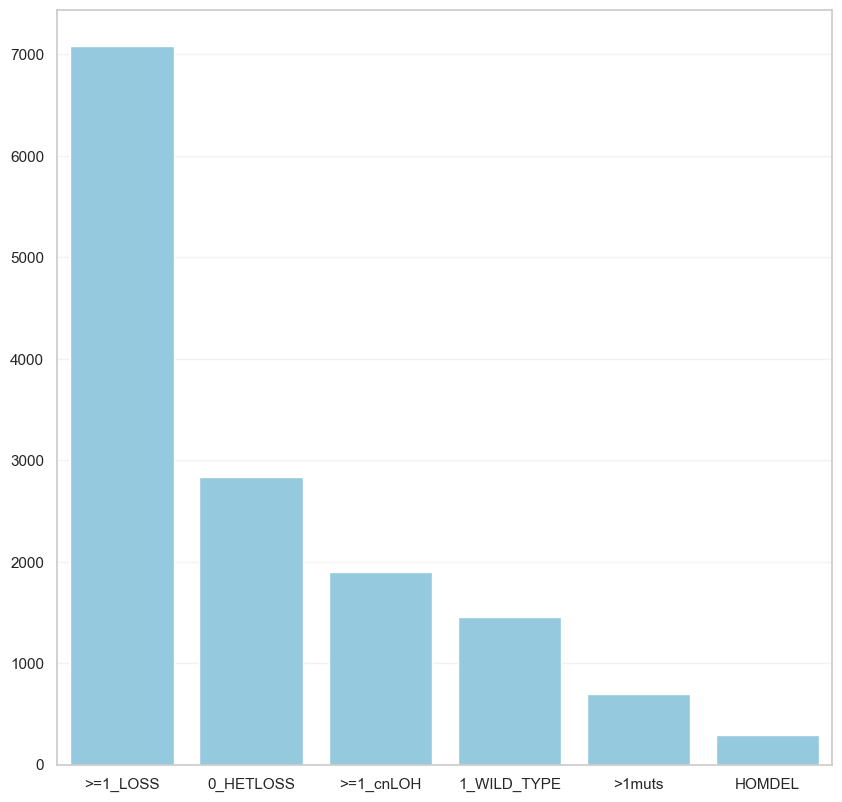

In [12]:
# First we will plot a Pan Group Summary, that Summarizes the global Information
sns.set_style("whitegrid", {'grid.color': '.95'})
h = pd.DataFrame(get_groupby(master, 'mut_cn_group', 'count').sort_values(by=['count'], ascending=False))
get_ploth(h['count'], h.index, h, '', '', '', color='skyblue', figsize=(10,10), perc=False)

In [109]:
mut_tp53_count = pd.DataFrame(master[['mut_cn_group', 'tp53_count']].groupby(['mut_cn_group', 'tp53_count'], sort = True).size())
mut_tp53_count.columns = ['count']
mut_tp53_count

count
mut_cn_group tp53_count       
0_HETLOSS    0            2833
1_WILD_TYPE  1            1457
>1muts       2             616
             3              68
             4              10
             5               3
>=1_LOSS     1            6904
             2             161
             3              19
             4               3
>=1_cnLOH    1            1850
             2              39
             3               6
HOMDEL       0             224
             1              63
             2               8
             4               1

In [69]:
list(mut_tp53_count.groupby(['mut_cn_group']).sum()['count'])

[2833, 1457, 697, 7087, 1895, 296]

In [95]:
group_names = ['>=1_LOSS','0_HETLOSS', '>=1_cnLOH', '1_WILD_TYPE', '>1muts', 'HOMDEL']
group_size = sorted(list(mut_tp53_count.groupby(['mut_cn_group']).sum()['count']), reverse=True)
subgroup_size = list(mut_tp53_count['count'])
subgroup_names = list(mut_tp53_count.index.get_level_values('tp53_count'))

[0, 1, 2, 3, 4, 5, 1, 2, 3, 4, 1, 2, 3, 0, 1, 2, 4]

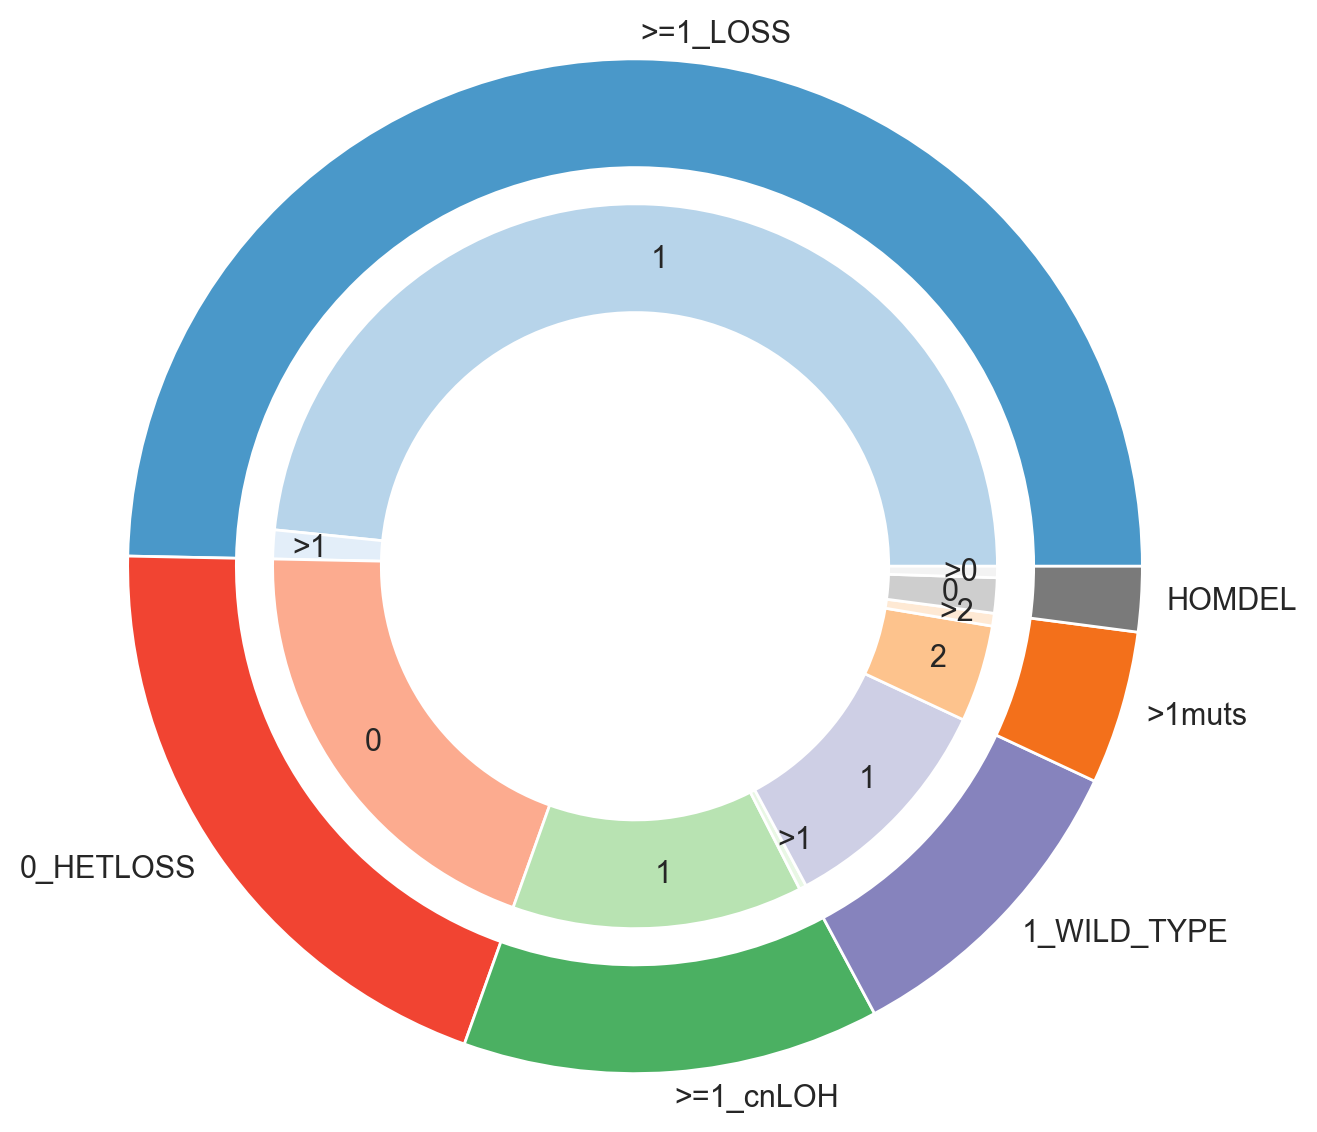

In [153]:
''' # Make data: I have 3 groups and 7 subgroups
group_names=['groupA', 'groupB', 'groupC']
group_size=[12,11,30]
subgroup_names=['A.1', 'A.2', 'A.3', 'B.1', 'B.2', 'C.1', 'C.2', 'C.3', 'C.4', 'C.5']
subgroup_size=[4,3,5,6,5,10,5,5,4,6]
'''
group_names = ['>=1_LOSS','0_HETLOSS', '>=1_cnLOH', '1_WILD_TYPE', '>1muts', 'HOMDEL']
group_size = sorted(list(mut_tp53_count.groupby(['mut_cn_group']).sum()['count']), reverse=True)
subgroup_size = [6904, 183, 2833, 1850, 45, 1457, 616, 81, 224, 72]
subgroup_names = [1, '>1', 0, 1, '>1', 1, 2, '>2', 0, '>0']


# Create colors
a, b, c, d, e, f=[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens, plt.cm.Purples, plt.cm.Oranges, plt.cm.Greys]
 
# First Ring (outside)
fig, ax = plt.subplots()
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.4, labels=group_names,labeldistance=1.05, colors=[a(0.6), b(0.6), c(0.6),d(0.6),e(0.6),f(0.6)] )
plt.setp( mypie, width=0.3, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size, radius=1.4-0.4, labels=subgroup_names, labeldistance=0.85, colors=[a(0.3),a(0.1), b(0.3), c(0.3), c(0.1), d(0.3), e(0.3), e(0.1), f(0.3), f(0.1)])
plt.setp( mypie2, width=0.3, edgecolor='white')
plt.margins(0,0)
   
# show it
plt.show()


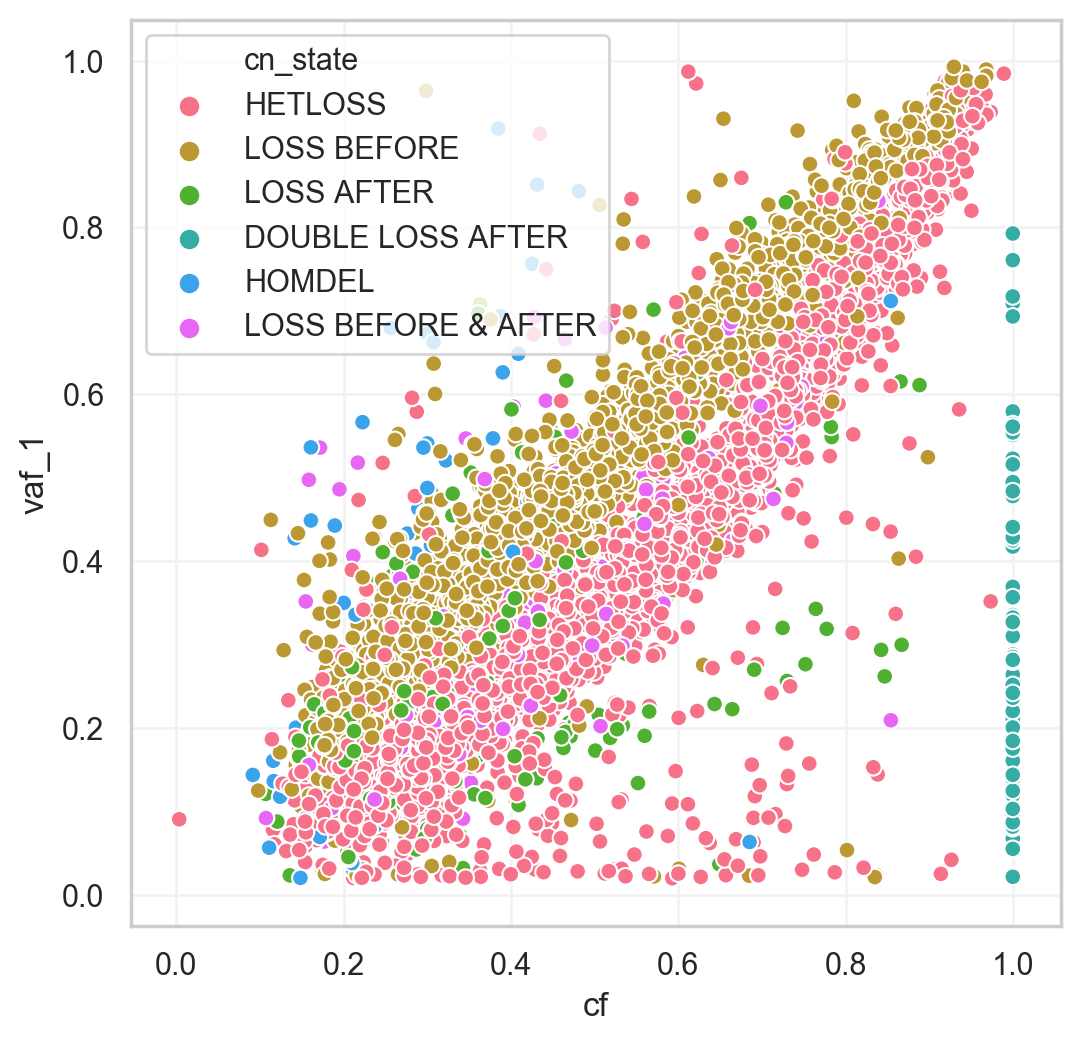

In [147]:
# Plot CCF_1 against cf corrected
def f(x):
    return x.cf/x.purity



master_density = filter_muts(master,[1,2,3])
master_density = filter_cn_state(master_density, LOSS)

master_density['adjusted_cf'] = master_density.apply(f, axis=1)

ax = sns.scatterplot(x='cf', y='vaf_1', data=master_density, hue='cn_state')

#ax = sns.distplot(master_density[master_density['cn_state'] == 'CNLOH']['adjusted_cf'], hist=False)
#ax = sns.distplot(master_density[master_density['cn_state'] == 'CNLOH']['exp_nb_1'], hist=False, vertical= True)

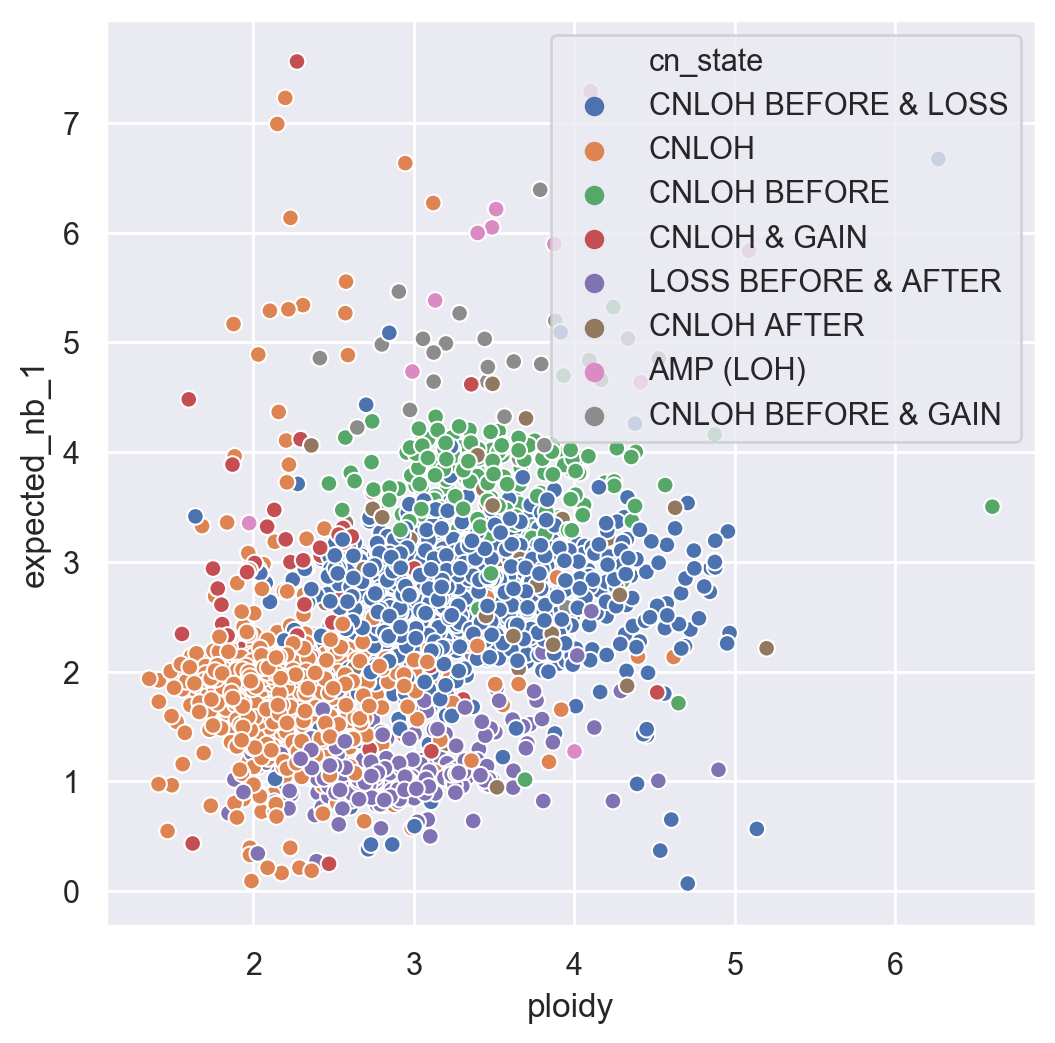

In [378]:
# Plot ploidy VS expected_nb_mut
def g(x):
    if x.tcn:
        return (x.vaf_1 / x.purity) * (x.tcn * x.purity + 2*(1 - x.purity))
    
master_density = filter_muts(master,[1,2,3])
master_density = filter_cn_state(master_density, loh)

master_density['expected_nb_1'] = master_density.apply(lambda x:(x.vaf_1 / x.purity) * (x.tcn * x.purity + 2*(1 - x.purity)), axis=1)
master_density['expected_nb_2'] = master_density.apply(lambda x:(x.vaf_2 / x.purity) * (x.tcn * x.purity + 2*(1 - x.purity)), axis=1)
master_density['expected_nb_3'] = master_density.apply(lambda x:(x.vaf_3 / x.purity) * (x.tcn * x.purity + 2*(1 - x.purity)), axis=1)

ax = sns.scatterplot(x='ploidy', y='expected_nb_1', data=master_density, hue='cn_state')
#ax = sns.distplot(master_density['ploidy'], hist=False)
#ax = sns.distplot(master_density['expected_nb_1'], hist=False, vertical= True)